# Exercise 2

This notebook serves as a comprehensive solution to Exercise 2 of the VU Machine Learning course (Summer Semester 2025). The primary objective of this exercise is to deepen our understanding of Neural Networks (NNs) by implementing them using various approaches and conducting a thorough comparative analysis. All approaches are applied to the [Polish Bankruptcies Dataset](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) as well as the [Second Dataset]().

Throughout this notebook, for each of the above mentioned datasets, we will:

- Implement a Neural Network framework from scratch: The architecture, backward and forward propagation and the entire network are built within the **nn** folder in this repo.

- Implement the same Neural Network using PyTorch: We leverage PyTorch's standard functions to create an equivalent NN, showcasing a more conventional approach to NN development.

- Utilize an LLM tool for NN implementation: Using ChatGPT 4o to generate another version of the NN from scratch, allowing for a direct comparison of code structure, design choices, and potential differences with our custom implementation.

- Investigate and experiment with NN configurations: We explore various hyperparameters, including different activation functions, numbers of layers, and nodes per layer, using a grid search approach to find optimal values.

- Analyze performance and resource usage: We calculate the total number of learnable parameters and the virtual RAM consumed by our instantiated NNs.

- Conduct a detailed comparison: The core of this notebook involves comparing the performance, efficiency, and implementation details across our custom-built NN, the PyTorch version, and the LLM-generated code. We discuss findings related to classification performance metrics and the insights gained from each implementation method.

### Setup and Imports

In [3]:
import pandas as pd
import numpy as np

from nn_from_scratch.nn import NN
from nn_from_scratch.layer import Layer
from nn_from_scratch.functions import *

## Polish Bankruptcy Dataset

### Analytics, Visualizations and Insights

In [4]:
from nn_from_scratch.nn import NN
from nn_from_scratch.layer import Layer
from nn_from_scratch.functions import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
import torch.nn as tnn  # сохраняем оригинальный nn под другим именем

from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.
(43405, 66)
Index(['year', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20',
       'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30',
       'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40',
       'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50',
       'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60',
       'A61', 'A62', 'A63', 'A64', 'class'],
      dtype='object')
   year        A1       A2       A3      A4       A5       A6        A7  \
0     1  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760   
1     1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340   
2     1  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060   
3     1  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704   
4     1  0.187320  

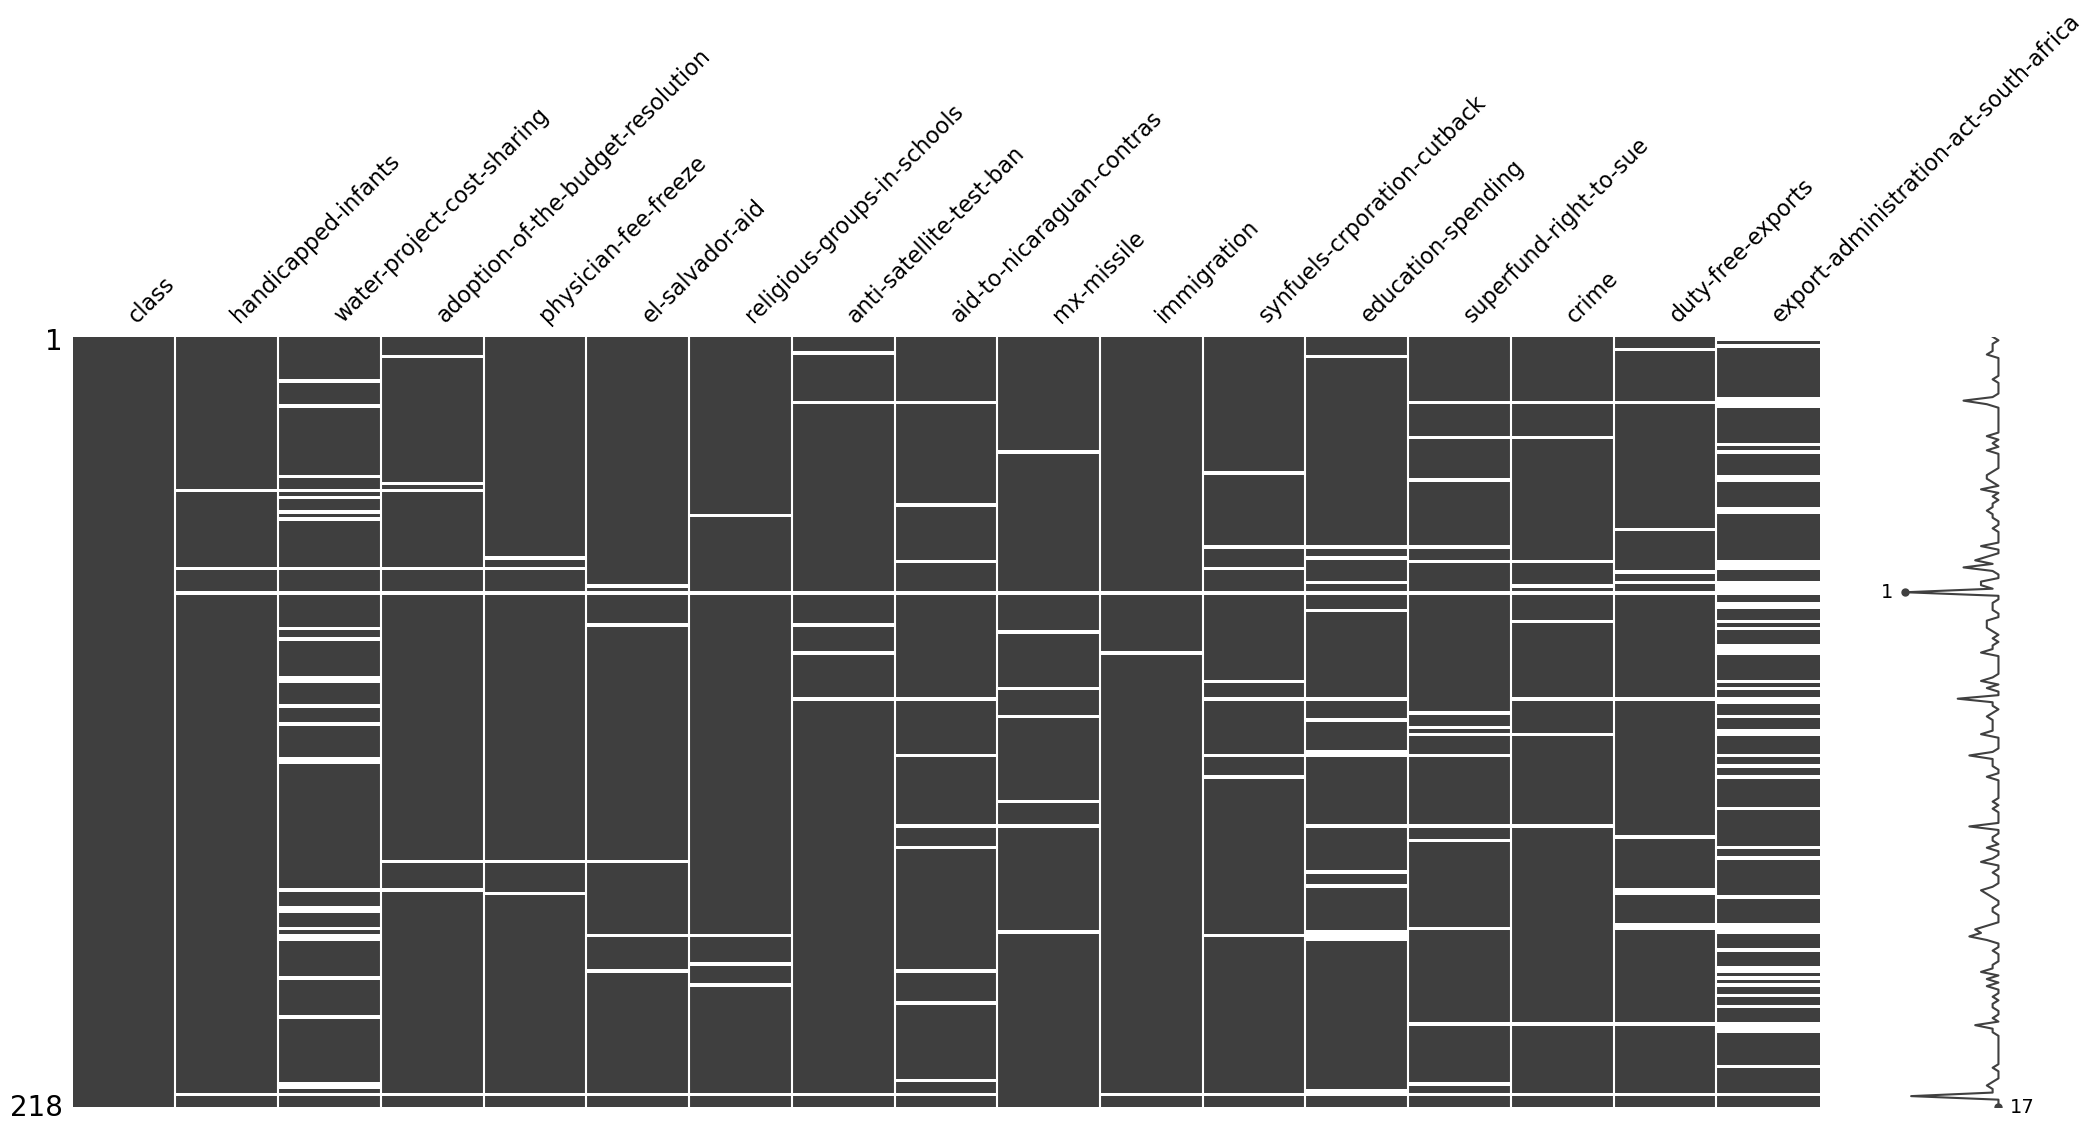

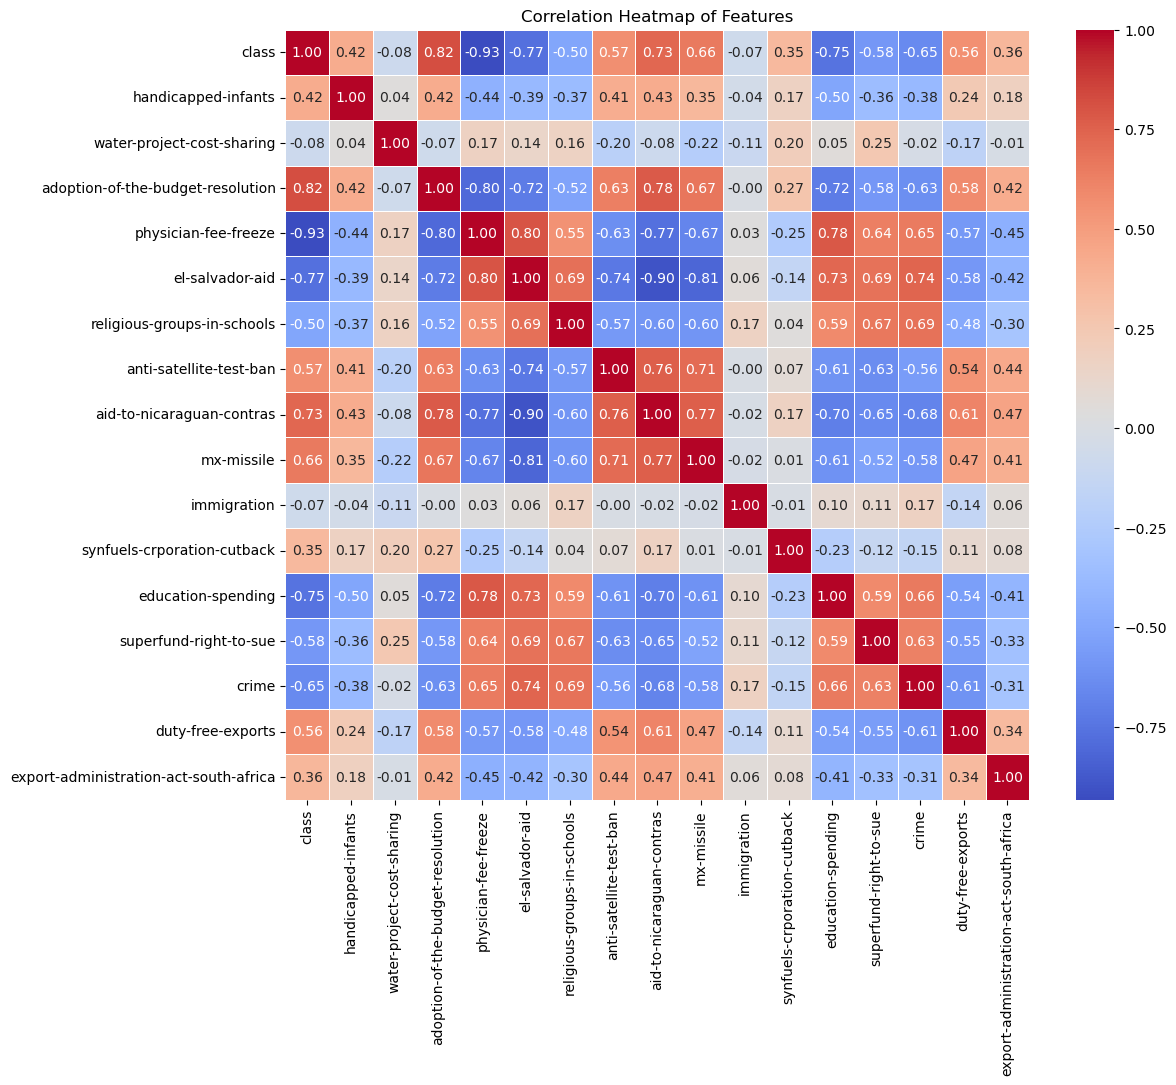

NaN in X_train: tensor(False)
NaN in y_train: tensor(False)
Shapes:
X_train: torch.Size([174, 16]), y_train: torch.Size([174])
X_val: torch.Size([44, 16]), y_val: torch.Size([44])


In [5]:
%run dataset_preprocessing.ipynb
X_train = pd.read_csv('data/bankruptcy_train_features.csv').values
X_test = pd.read_csv('data/bankruptcy_test_features.csv').values
y_train = pd.read_csv('data/bankruptcy_train_target.csv').values
y_test = pd.read_csv('data/bankruptcy_test_target.csv').values

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1.]), array([33052, 33052], dtype=int64)),
 (array([0., 1.]), array([8262,  419], dtype=int64)))

### Custom NN Modeling and Evaluation

In [7]:
X_train_np = X_train.numpy() if isinstance(X_train, torch.Tensor) else X_train
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
X_test_np  = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
y_test_np  = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test


In [ ]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Подсчёт параметров и памяти
def get_custom_model_info(model):
    total_params = 0
    memory_bytes = 0
    for layer in model.layers:
        total_params += layer.weights.size + layer.biases.size
        memory_bytes += layer.weights.nbytes + layer.biases.nbytes
    return total_params, memory_bytes

# Конфигурации
activations = ['relu', 'sigmoid', 'tanh', 'softmax']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
results = []

# Перебор конфигураций
for activation in activations:
    for config in layer_configs:
        print(f"\nTraining with activation={activation}, layers={config}")
        layers = []

        in_size = X_train.shape[1]
        for out_size in config:
            layers.append(Layer(input_size=in_size, output_size=out_size, activation_function=activation))
            in_size = out_size
        layers.append(Layer(input_size=in_size, output_size=1, activation_function=activation))

        nn_model = NN(layers=layers, num_classes=1, activation_function=activation, loss_function='mean_squared_error')

        start = time.time()
        nn_model.train(X_train_np, y_train_np,
                       epochs=200,
                       batch_size=1000,
                       learning_rate=0.001,
                       verbose=False,
                       visualize=False)
        end = time.time()

        y_pred_test = nn_model.predict(X_test)
        y_pred_test = (y_pred_test > 0.5).astype(int)

        metrics = {
            'Accuracy': round(accuracy_score(y_test, y_pred_test), 4),
            'Precision': round(precision_score(y_test, y_pred_test, zero_division=0), 4),
            'Recall': round(recall_score(y_test, y_pred_test, zero_division=0), 4),
            'F1': round(f1_score(y_test, y_pred_test, zero_division=0), 4),
        }


        params, memory = get_custom_model_info(nn_model)
        results.append({
            'Activation': activation,
            'Hidden Layers': str(config),
            **metrics,
            'Train Time (s)': round(end - start, 4),
            'Params': params,
            'Memory (MB)': round(memory / (1024 ** 2), 4)
        })




Training with activation=relu, layers=[32, 16]


100%|██████████| 200/200 [00:46<00:00,  4.33it/s]



Training with activation=relu, layers=[64, 32]


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]



Training with activation=relu, layers=[128, 64, 32]


100%|██████████| 200/200 [01:35<00:00,  2.09it/s]



Training with activation=sigmoid, layers=[32, 16]


100%|██████████| 200/200 [00:36<00:00,  5.50it/s]



Training with activation=sigmoid, layers=[64, 32]


100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



Training with activation=sigmoid, layers=[128, 64, 32]


100%|██████████| 200/200 [02:25<00:00,  1.38it/s]



Training with activation=tanh, layers=[32, 16]


100%|██████████| 200/200 [00:43<00:00,  4.56it/s]



Training with activation=tanh, layers=[64, 32]


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]



Training with activation=tanh, layers=[128, 64, 32]


 92%|█████████▏| 184/200 [02:35<00:13,  1.14it/s]

In [ ]:
# Сортировка по F1 (можно изменить на 'Accuracy' и т.д.)
sorted_results = sorted(results, key=lambda x: x['Accuracy'], reverse=True)

# Вывод результатов
print("\n📊 Final Results (sorted by Accuracy):")
for res in sorted_results:
    print(res)



📊 Final Results (sorted by F1):
{'Activation': 'softmax', 'Hidden Layers': '[32, 16]', 'Accuracy': 0.04803594055984334, 'Precision': 0.04803594055984334, 'Recall': 1.0, 'F1': 0.09166849857111453, 'Train Time (s)': 16.31, 'Params': 2625, 'Memory (MB)': 0.01}
{'Activation': 'softmax', 'Hidden Layers': '[64, 32]', 'Accuracy': 0.04803594055984334, 'Precision': 0.04803594055984334, 'Recall': 1.0, 'F1': 0.09166849857111453, 'Train Time (s)': 22.26, 'Params': 6273, 'Memory (MB)': 0.0239}
{'Activation': 'softmax', 'Hidden Layers': '[128, 64, 32]', 'Accuracy': 0.04803594055984334, 'Precision': 0.04803594055984334, 'Recall': 1.0, 'F1': 0.09166849857111453, 'Train Time (s)': 38.61, 'Params': 18689, 'Memory (MB)': 0.0713}
{'Activation': 'relu', 'Hidden Layers': '[32, 16]', 'Accuracy': 0.9519640594401567, 'Precision': 0.5, 'Recall': 0.002398081534772182, 'F1': 0.00477326968973747, 'Train Time (s)': 12.88, 'Params': 2625, 'Memory (MB)': 0.01}
{'Activation': 'relu', 'Hidden Layers': '[64, 32]', 'Acc

### Pytorch Implementation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
import torch.nn as tnn  # сохраняем оригинальный nn под другим именем

from tqdm import tqdm


In [ ]:
from sklearn.model_selection import train_test_split

# Предположим, X_train и y_train — из загруженного файла
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42  # 20% пойдет на валидацию
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

y_train = torch.tensor(y_train_np.squeeze(), dtype=torch.long)
y_test = torch.tensor(y_test_np.squeeze(), dtype=torch.long)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time

# Обеспечиваем корректные типы и формы
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

if y_train.ndim == 1:
    y_train = y_train.unsqueeze(1)
    y_val = y_val.unsqueeze(1)
    y_test = y_test.unsqueeze(1)

# Flexible architecture
class FlexibleNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu'):
        super(FlexibleNet, self).__init__()
        self.activation = activation
        self.hidden_layers = nn.ModuleList()
        
        in_dim = input_dim
        for h_dim in hidden_layers:
            self.hidden_layers.append(nn.Linear(in_dim, h_dim))
            in_dim = h_dim
        
        self.output_layer = nn.Linear(in_dim, 1)

    def _activate(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'softmax':  # Заглушка (на самом деле это step)
            return (x > 0).float()
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self._activate(layer(x))
        return torch.sigmoid(self.output_layer(x))  # Binary classification


# Метрики
def evaluate_binary(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).cpu().numpy().astype(int)
    y_true = y_true.cpu().numpy().astype(int)

    return {
        "Accuracy": accuracy_score(y_true, y_pred_binary),
        "Precision": precision_score(y_true, y_pred_binary, zero_division=0),
        "Recall": recall_score(y_true, y_pred_binary, zero_division=0),
        "F1": f1_score(y_true, y_pred_binary, zero_division=0)
    }

# Параметры модели
def get_model_info(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.element_size() * p.numel() for p in model.parameters())
    return total_params, total_bytes

# Конфигурации
activations = ['relu', 'sigmoid', 'tanh', 'softmax']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
epochs = 20
results = []

for act in activations:
    for config in layer_configs:
        print(f"\nTraining config: activation={act}, layers={config}")
        model = FlexibleNet(X_train.shape[1], config, activation=act)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_accuracies = []
        pbar = tqdm(range(epochs), desc=f"{act} {config}", leave=False)

        start_time = time.time()

        for epoch in pbar:
            model.train()
            preds = model(X_train)
            loss = criterion(preds, y_train)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_preds = model(X_val)
                    val_acc = ((val_preds > 0.5) == y_val).float().mean().item()
                    val_accuracies.append(val_acc)
                pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Val Acc': f"{val_acc:.4f}"})

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            test_loss = criterion(test_preds, y_test).item()
            metrics = evaluate_binary(y_test, test_preds)

        total_params, memory_bytes = get_model_info(model)
        train_time = time.time() - start_time

        results.append({
            "Activation": act,
            "Hidden Layers": str(config),
            "Test Loss": round(test_loss, 4),
            "Accuracy": round(metrics["Accuracy"], 4),
            "Precision": round(metrics["Precision"], 4),
            "Recall": round(metrics["Recall"], 4),
            "F1": round(metrics["F1"], 4),
            "Train Time (s)": round(train_time, 2),
            "Params": total_params,
            "Memory (MB)": round(memory_bytes / (1024 ** 2), 4)
        })

# Сортировка по F1
sorted_results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)

# Вывод
print("\nFinal Results (sorted by F1):")
for res in sorted_results:
    print(res)



Training config: activation=relu, layers=[32, 16]



Training config: activation=relu, layers=[64, 32]



Training config: activation=relu, layers=[128, 64, 32]



Training config: activation=sigmoid, layers=[32, 16]



Training config: activation=sigmoid, layers=[64, 32]



Training config: activation=sigmoid, layers=[128, 64, 32]



Training config: activation=tanh, layers=[32, 16]



Training config: activation=tanh, layers=[64, 32]



Training config: activation=tanh, layers=[128, 64, 32]



Training config: activation=softmax, layers=[32, 16]



Training config: activation=softmax, layers=[64, 32]



Training config: activation=softmax, layers=[128, 64, 32]



Final Results (sorted by F1):
{'Activation': 'relu', 'Hidden Layers': '[32, 16]', 'Test Loss': 0.6939, 'Accuracy': 0.2636, 'Precision': 0.0519, 'Recall': 0.8297, 'F1': 0.0977, 'Train Time (s)': 0.28, 'Params': 2625, 'Memory (MB)': 0.01}
{'Activation': 'softmax', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.7013, 'Accuracy': 0.499, 'Precision': 0.0449, 'Recall': 0.4652, 'F1': 0.0819, 'Train Time (s)': 0.23, 'Params': 6273, 'Memory (MB)': 0.0239}
{'Activation': 'softmax', 'Hidden Layers': '[128, 64, 32]', 'Test Loss': 0.6267, 'Accuracy': 0.8015, 'Precision': 0.0375, 'Recall': 0.1271, 'F1': 0.058, 'Train Time (s)': 0.29, 'Params': 18689, 'Memory (MB)': 0.0713}
{'Activation': 'tanh', 'Hidden Layers': '[32, 16]', 'Test Loss': 0.5655, 'Accuracy': 0.9484, 'Precision': 0.1837, 'Recall': 0.0216, 'F1': 0.0386, 'Train Time (s)': 0.24, 'Params': 2625, 'Memory (MB)': 0.01}
{'Activation': 'tanh', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.4899, 'Accuracy': 0.9441, 'Precision': 0.0952, 'Recall': 0.0

In [ ]:
print("Train positive rate:", y_train.mean().item())
print("Test positive rate:", y_test.mean().item())


Train positive rate: 0.048309873789548874
Test positive rate: 0.048035942018032074


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\lesya\ML\ex2\Exercise-2\nn_from_scratch\functions.py:20: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-x))
100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


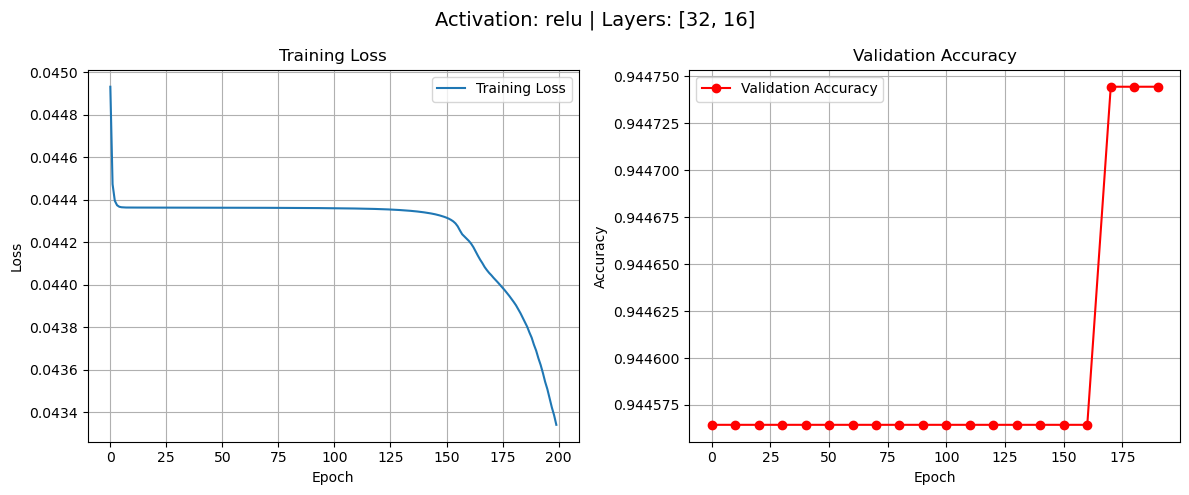

100%|██████████| 1/1 [00:00<00:00,  9.23it/s]
c:\Users\lesya\ML\ex2\Exercise-2\nn_from_scratch\functions.py:20: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-x))
100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


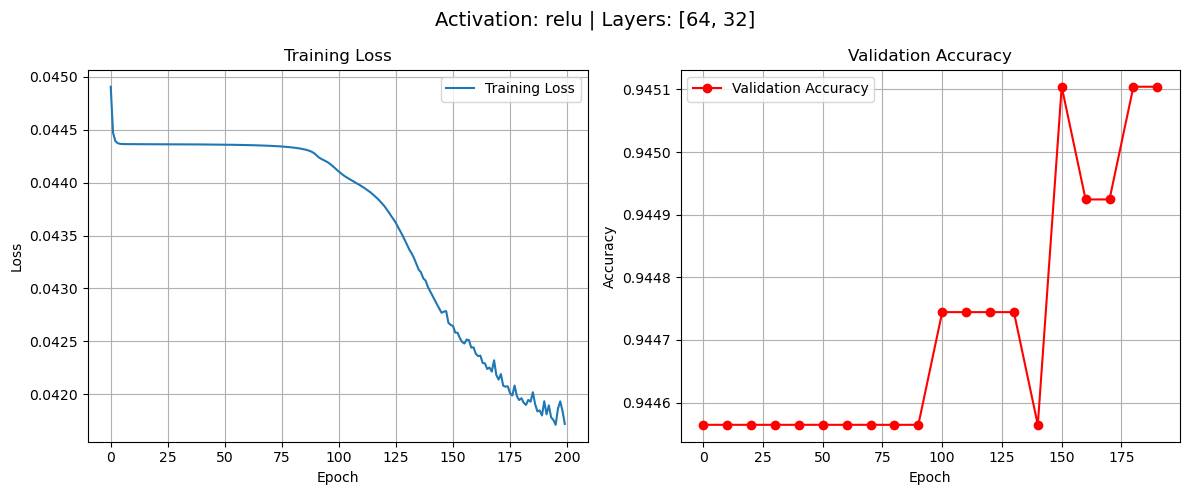

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


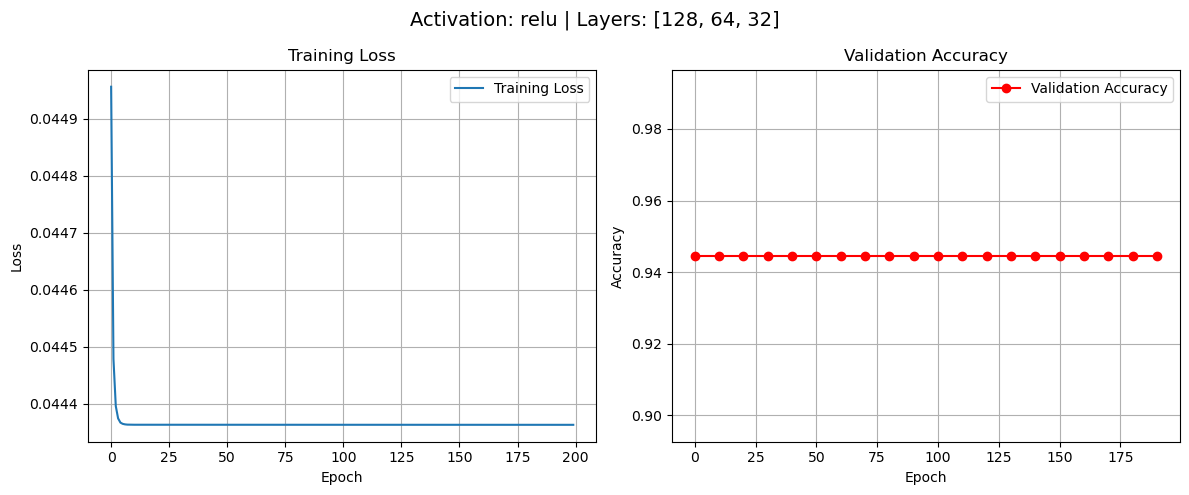

100%|██████████| 1/1 [00:00<00:00, 15.37it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


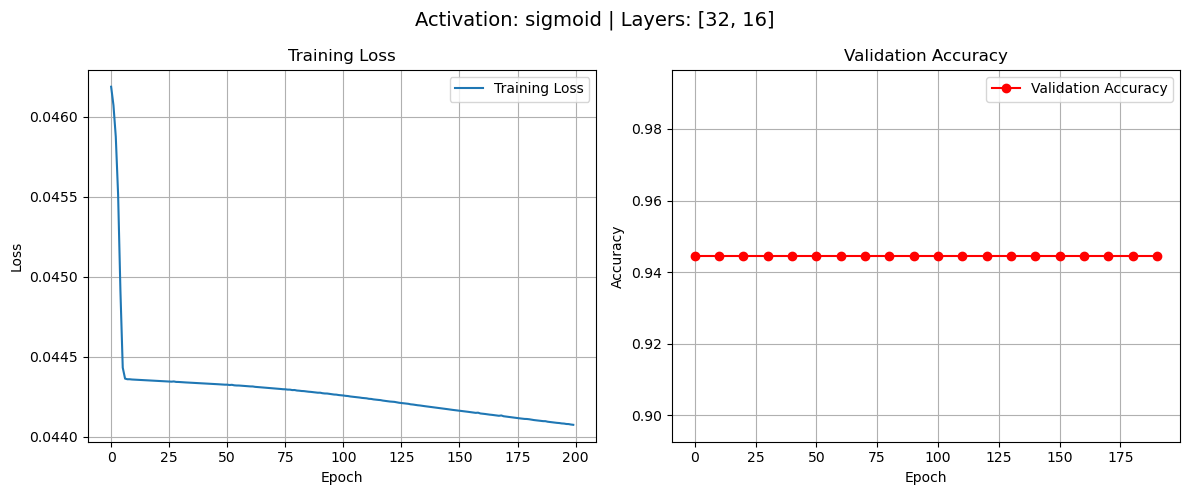

100%|██████████| 1/1 [00:00<00:00, 10.60it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


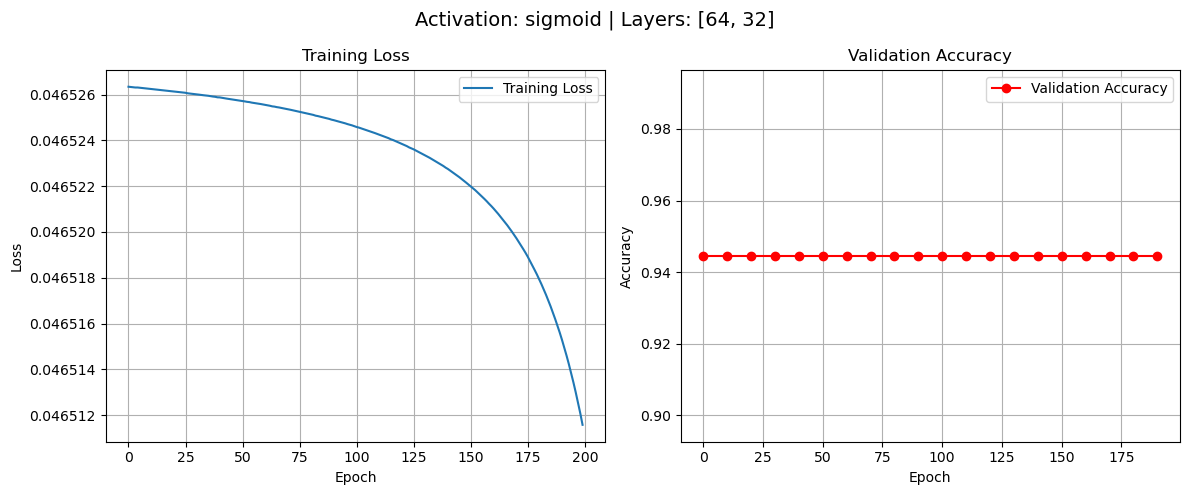

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


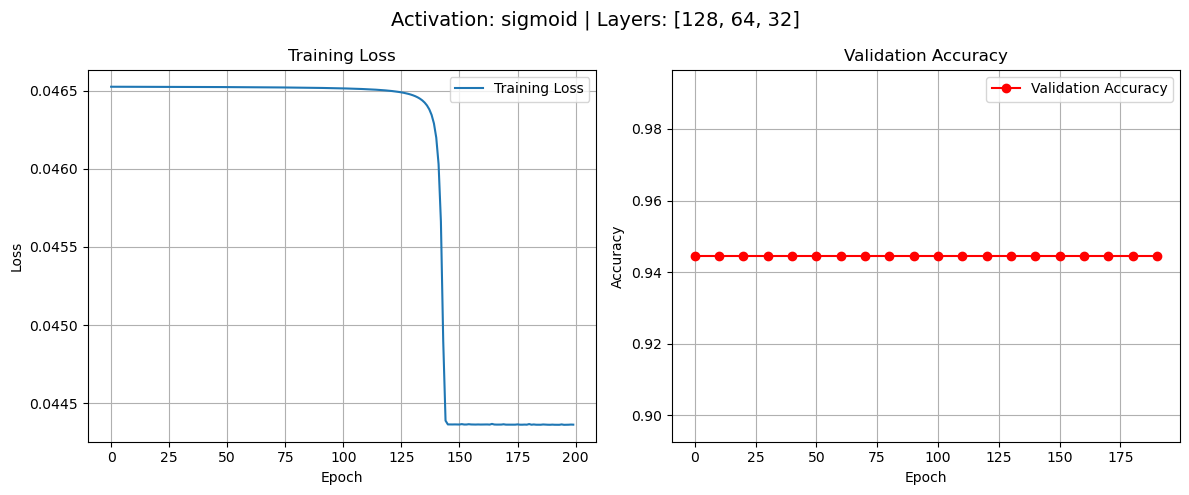

100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


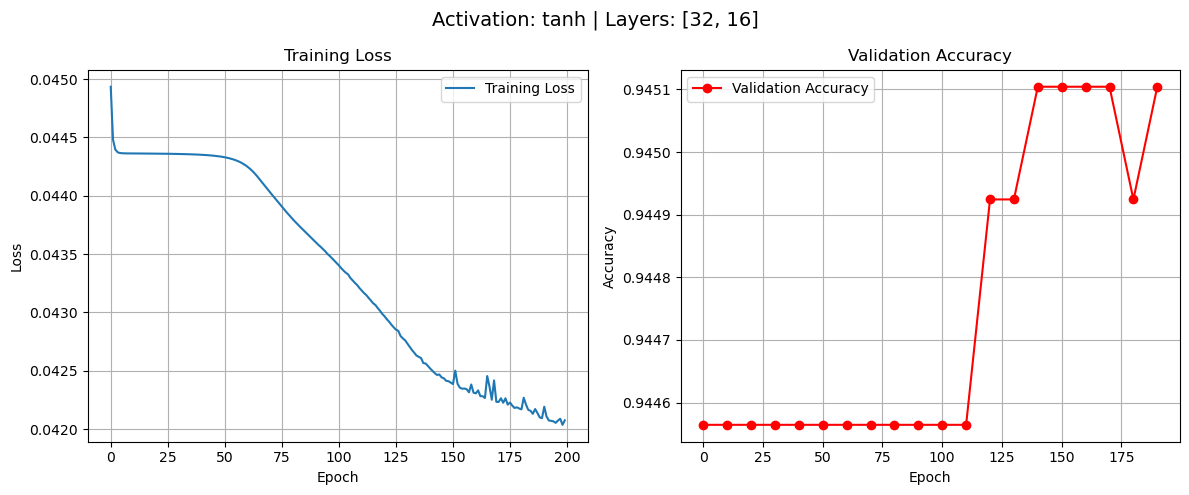

100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


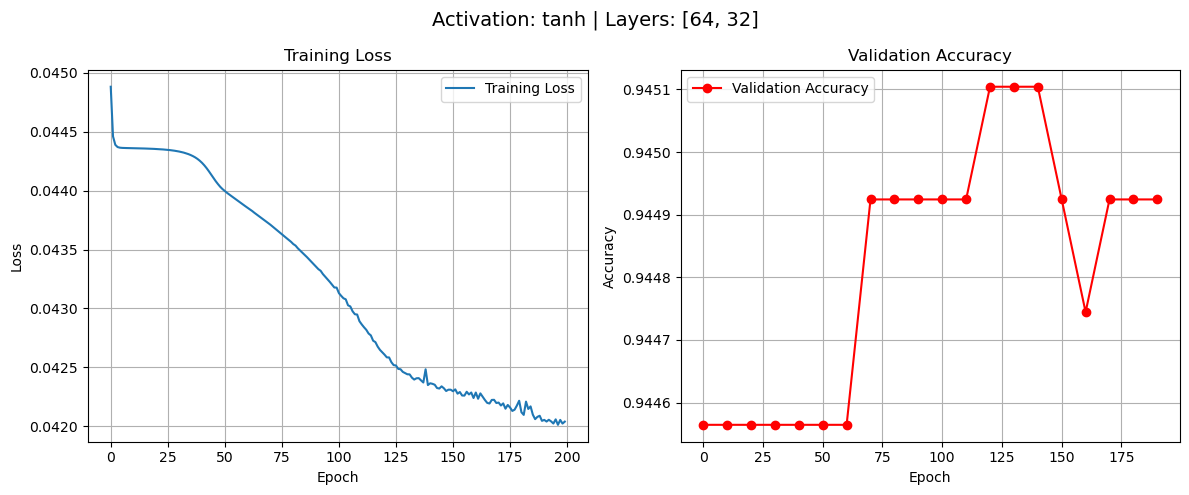

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


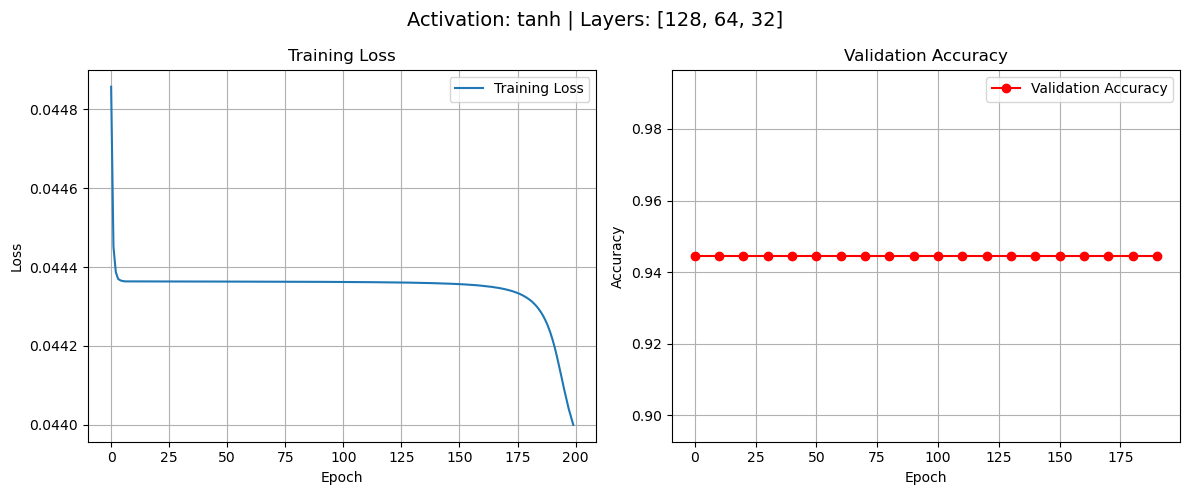

100%|██████████| 1/1 [00:00<00:00, 14.89it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


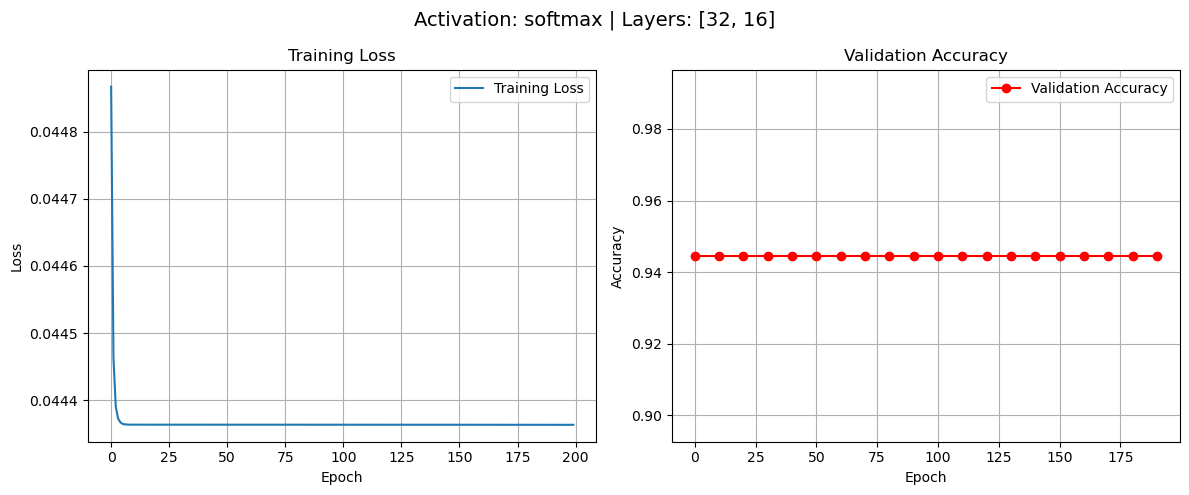

100%|██████████| 1/1 [00:00<00:00, 11.65it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


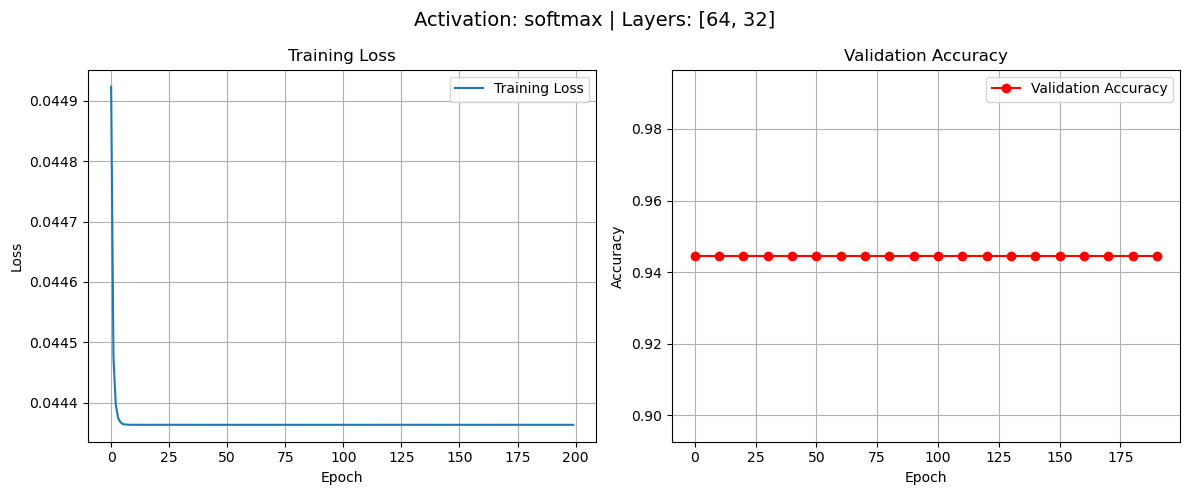

100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
c:\Users\lesya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


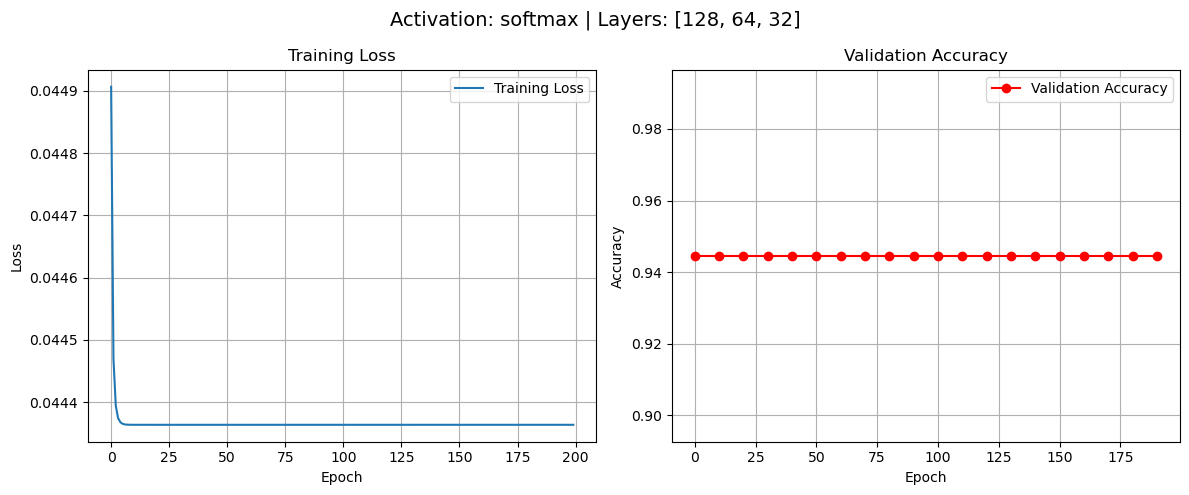


Final Results (sorted by F1):
{'Activation': 'relu', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.0435, 'Test Accuracy': 0.952, 'Precision': 0.5, 'Recall': 0.0096, 'F1': 0.0188, 'Train Time (s)': 22.68, 'Params': 6176, 'Memory (MB)': 0.0236}
{'Activation': 'tanh', 'Hidden Layers': '[32, 16]', 'Test Loss': 0.0437, 'Test Accuracy': 0.9518, 'Precision': 0.4, 'Recall': 0.0048, 'F1': 0.0095, 'Train Time (s)': 11.77, 'Params': 2576, 'Memory (MB)': 0.0098}
{'Activation': 'tanh', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.0436, 'Test Accuracy': 0.9516, 'Precision': 0.2857, 'Recall': 0.0048, 'F1': 0.0094, 'Train Time (s)': 17.23, 'Params': 6176, 'Memory (MB)': 0.0236}
{'Activation': 'relu', 'Hidden Layers': '[32, 16]', 'Test Loss': 0.0447, 'Test Accuracy': 0.9518, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Train Time (s)': 12.76, 'Params': 2576, 'Memory (MB)': 0.0098}
{'Activation': 'relu', 'Hidden Layers': '[128, 64, 32]', 'Test Loss': 0.0457, 'Test Accuracy': 0.952, 'Precision': 0.0, 'Reca

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import sys
sys.path.append('./nn_by_llm')

# Функция оценки модели
def evaluate_binary(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    y_true = y_true.astype(int)

    return {
        "Accuracy": accuracy_score(y_true, y_pred_binary),
        "Precision": precision_score(y_true, y_pred_binary),
        "Recall": recall_score(y_true, y_pred_binary),
        "F1": f1_score(y_true, y_pred_binary)
    }

# Функция подсчёта параметров и памяти
def get_model_info(model):
    total_params = 0
    total_bytes = 0
    for layer in model.layers:
        w = layer.weights  # единственное, что есть
        total_params += w.size
        total_bytes += w.nbytes
    return total_params, total_bytes


# Данные
X_train_np = X_train_np.astype(np.float32)
X_test_np = X_test_np.astype(np.float32)
y_train_np = y_train_np.astype(np.float32).reshape(-1, 1)
y_test_np = y_test_np.astype(np.float32).reshape(-1, 1)

# Сплит на train/val для графика
X_train_final, X_val_np, y_train_final, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42)

# Конфигурации
activations = ['relu', 'sigmoid', 'tanh', 'softmax']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
epochs = 200
learning_rate = 0.01
batch_size = 1000
eval_interval = 10

results = []

for activation in activations:
    for config in layer_configs:
        # Построение модели
        layers = []
        input_dim = X_train_final.shape[1]
        for hidden_dim in config:
            layers.append(Layer(input_size=input_dim, output_size=hidden_dim, activation_function=activation))
            input_dim = hidden_dim
        layers.append(Layer(input_size=input_dim, output_size=1, activation_function='sigmoid'))

        model = NN(layers=layers, num_classes=1, activation_function='sigmoid', loss_function='mean_squared_error')

        train_losses = []
        val_accuracies = []

        start_time = time.time()

        for epoch in range(epochs):
            model.train(X_train_final, y_train_final, epochs=1, learning_rate=learning_rate,
                        batch_size=batch_size, verbose=False)

            # Тренировочный лосс
            y_pred_train = model.predict(X_train_final)
            loss = mean_squared_error(y_train_final, y_pred_train)
            train_losses.append(loss)

            if epoch % eval_interval == 0:
                y_pred_val = model.predict(X_val_np)
                acc = np.mean((y_pred_val > 0.5) == y_val_np)
                val_accuracies.append(acc)

        # Финальная оценка
        train_time = time.time() - start_time
        y_pred_test = model.predict(X_test_np)

        metrics = evaluate_binary(y_test_np, y_pred_test)
        total_params, memory_bytes = get_model_info(model)

        results.append({
            "Activation": activation,
            "Hidden Layers": str(config),
            "Test Loss": round(mean_squared_error(y_test_np, y_pred_test), 4),
            "Test Accuracy": round(metrics["Accuracy"], 4),
            "Precision": round(metrics["Precision"], 4),
            "Recall": round(metrics["Recall"], 4),
            "F1": round(metrics["F1"], 4),
            "Train Time (s)": round(train_time, 2),
            "Params": total_params,
            "Memory (MB)": round(memory_bytes / (1024**2), 4)
        })

        # Графики
        plt.figure(figsize=(12, 5))
        plt.suptitle(f"Activation: {activation} | Layers: {config}", fontsize=14)

        # Training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid()
        plt.legend()

        # Validation accuracy
        plt.subplot(1, 2, 2)
        val_epochs = list(range(0, epochs, eval_interval))
        plt.plot(val_epochs, val_accuracies, 'r-o', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

# Сортировка по F1
sorted_results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)

# Вывод
print("\nFinal Results (sorted by Accuracy):")
for res in sorted_results:
    print(res)


### LLM Developed NN Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import sys

sys.path.append('./nn_by_llm')
import nn



# Метрики
def evaluate_metrics(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = (y_pred > 0.5).astype(int)
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Precision': round(precision_score(y_true, y_pred, zero_division=0), 4),
        'Recall': round(recall_score(y_true, y_pred, zero_division=0), 4),
        'F1': round(f1_score(y_true, y_pred, zero_division=0), 4)
    }

def model_stats(params):
    total_params = 0
    memory = 0
    for key in params:
        total_params += params[key].size
        memory += params[key].nbytes
    return total_params, round(memory / (1024**2), 4)

# Конфигурации
activations_list = ['relu', 'sigmoid', 'tanh']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
epochs = 200
eval_interval = 10
learning_rate = 0.01
results = []


# Перебор
for activation in activations_list:
    for config in layer_configs:
        print(f"\n🔧 Training: activation={activation}, layers={config}")

        # Архитектура
        layer_dims = [X_train_np.shape[1]] + config + [1]
        act_list = [activation] * len(config) + ['sigmoid']

        # Инициализация
        parameters = nn.initialize_parameters(layer_dims)
        train_losses = []
        val_accuracies = []

        start = time.time()

        for epoch in range(epochs):
            # Forward
            Y_hat, cache = nn.forward_propagation(X_train_np.T, parameters, act_list)

            # Loss
            loss = nn.compute_loss(Y_hat, y_train_np.T)
            train_losses.append(loss)

            # Validation
            if epoch % eval_interval == 0:
                val_pred, _ = nn.forward_propagation(X_val_np.T, parameters, act_list)
                acc = np.mean((val_pred > 0.5) == y_val_np.T)
                val_accuracies.append(acc)

            # Backward + update
            grads = nn.backward_propagation(X_train_np.T, y_train_np.T, parameters, cache, act_list)
            parameters = nn.update_parameters(parameters, grads, learning_rate)

        end = time.time()

        # Тест
        test_pred, _ = nn.forward_propagation(X_test_np.T, parameters, act_list)
        metrics = evaluate_metrics(y_test_np, test_pred.T)
        total_params, memory_mb = model_stats(parameters)

        results.append({
            "Activation": activation,
            "Hidden Layers": str(config),
            "Test Accuracy": metrics["Accuracy"],
            "Precision": metrics["Precision"],
            "Recall": metrics["Recall"],
            "F1": metrics["F1"],
            "Train Time (s)": round(end - start, 2),
            "Params": total_params,
            "Memory (MB)": memory_mb
        })

        # --- Графики ---
        plt.figure(figsize=(12, 5))
        plt.suptitle(f"Activation: {activation} | Layers: {config}", fontsize=14)

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()

        # Accuracy
        plt.subplot(1, 2, 2)
        val_epochs = list(range(0, epochs, eval_interval))
        plt.plot(val_epochs, val_accuracies, 'r-o')
        plt.title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid()

        plt.tight_layout()
        plt.show()

# --- Вывод ---
sorted_results = sorted(results, key=lambda x: x['F1'], reverse=True)
print("\n📊 Final Results (sorted by F1):")
for res in sorted_results:
    print(res)



🔧 Training: activation=relu, layers=[32, 16]


NameError: name 'X_train_np' is not defined

### Existing NN implemention (sklearn-MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Преобразуем тензоры в numpy
X_train_np = X_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_train_np = y_train_tensor.numpy().ravel()
y_val_np = y_val_tensor.numpy().ravel()

# Создаем модель
mlp = MLPClassifier(hidden_layer_sizes=(10, 5),  # 2 скрытых слоя
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.01,
                    max_iter=1000,
                    random_state=42)

# Обучение модели
mlp.fit(X_train_np, y_train_np)

# Предсказания
y_pred = mlp.predict(X_val_np)

# Метрики
accuracy = accuracy_score(y_val_np, y_pred)
precision = precision_score(y_val_np, y_pred, zero_division=0)
recall = recall_score(y_val_np, y_pred, zero_division=0)
f1 = f1_score(y_val_np, y_pred, zero_division=0)

# Вывод
print(f"Validation Accuracy (sklearn MLP): {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


### Comparison Across the Three Implemtations

## Congressional Voting Dataset

### Analytics, Visualization and Insights

Note: you may need to restart the kernel to use updated packages.
(43405, 66)
Index(['year', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20',
       'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30',
       'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40',
       'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50',
       'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60',
       'A61', 'A62', 'A63', 'A64', 'class'],
      dtype='object')
   year        A1       A2       A3      A4       A5       A6        A7  \
0     1  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760   
1     1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340   
2     1  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060   
3     1  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704   
4     1  0.187320  

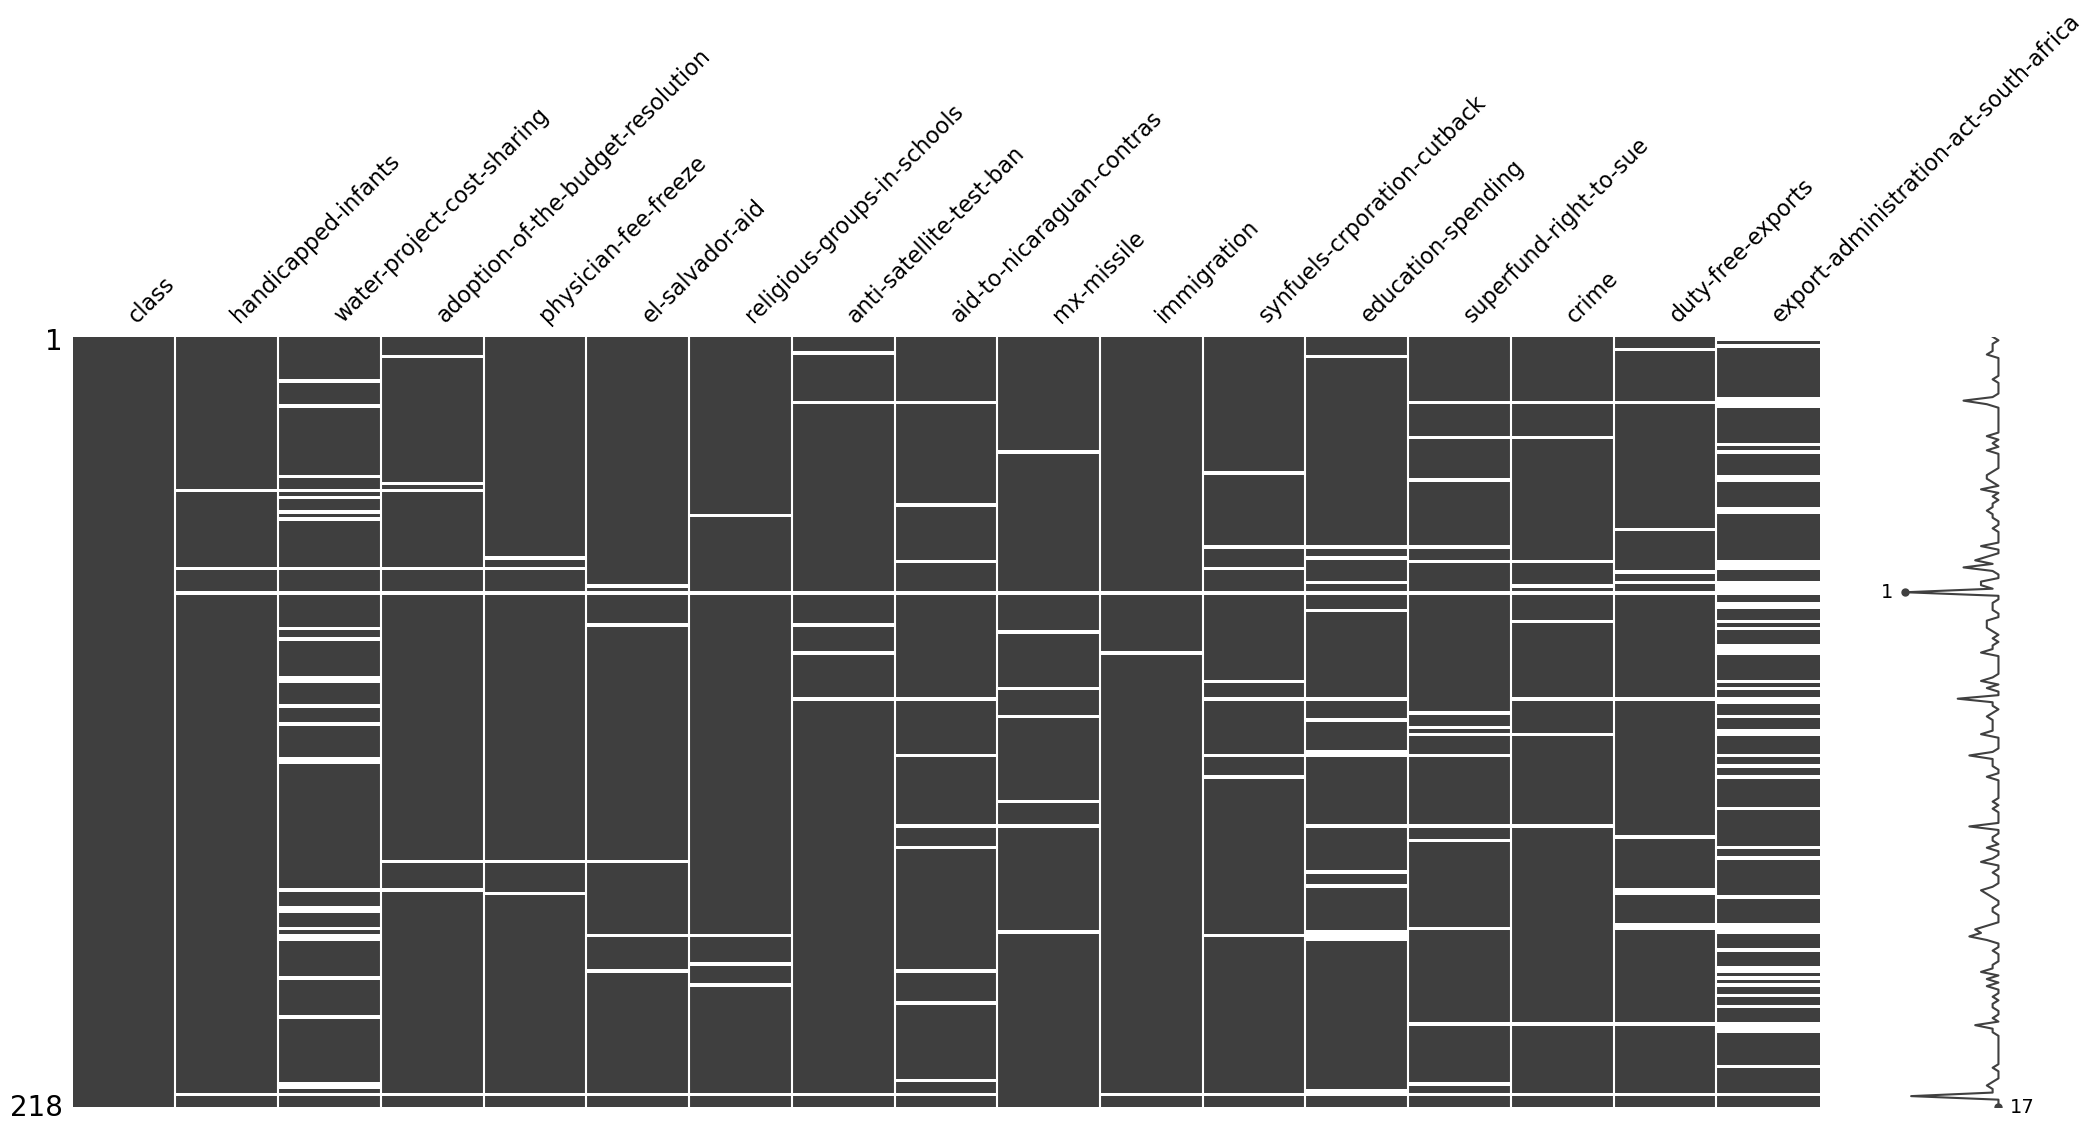

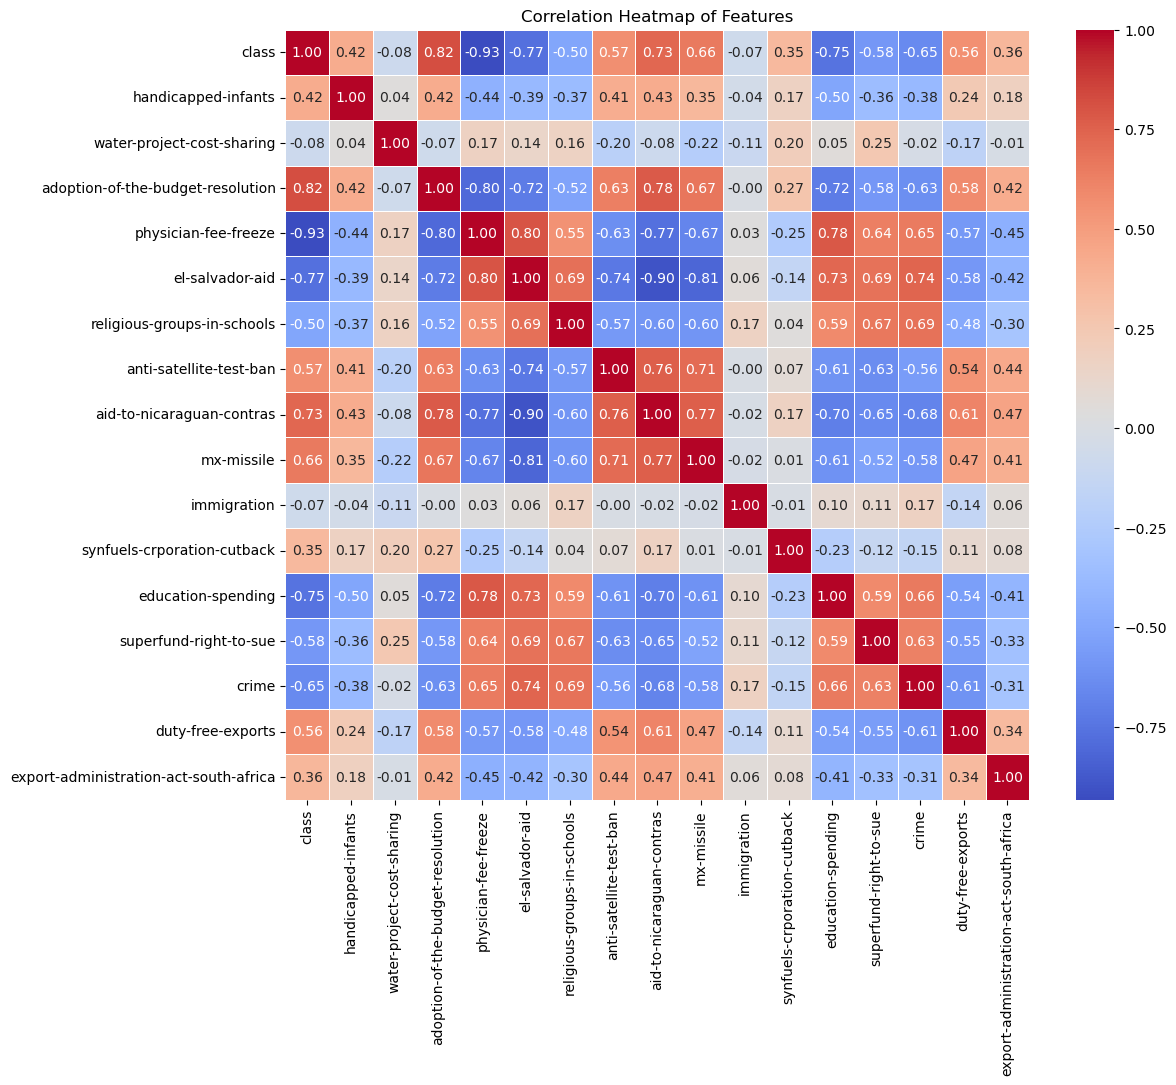

NaN in X_train: tensor(False)
NaN in y_train: tensor(False)
Shapes:
X_train: torch.Size([174, 16]), y_train: torch.Size([174])
X_val: torch.Size([44, 16]), y_val: torch.Size([44])


In [ ]:
%run dataset_preprocessing.ipynb

### Custom NN Implementation

In [ ]:
# Convert tensors to numpy arrays and adjust shape
X_train = X_train_tensor.numpy()   
y_train = y_train_tensor.numpy().reshape(1, -1)

X_val = X_val_tensor.numpy()
y_val = y_val_tensor.numpy().reshape(1, -1)

X_train_np = X_train.numpy() if isinstance(X_train, torch.Tensor) else X_train
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
X_test_np  = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
y_test_np  = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test

y_train_np = y_train_np.reshape(-1, 1)
y_test_np = y_test_np.reshape(-1, 1)
X_test_np = X_test_np.T
y_test_np = y_test_np.T


In [ ]:
print("Train shape:", X_train_np.shape)
print("Test shape:", X_test_np.shape)
print("Weight shape:", nn_model.layers[0].weights.shape)


Train shape: (174, 16)
Test shape: (44, 16)
Weight shape: (16, 32)


In [ ]:




import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Подсчёт параметров и памяти
def get_custom_model_info(model):
    total_params = 0
    memory_bytes = 0
    for layer in model.layers:
        total_params += layer.weights.size + layer.biases.size
        memory_bytes += layer.weights.nbytes + layer.biases.nbytes
    return total_params, memory_bytes

# Конфигурации
activations = ['relu', 'sigmoid', 'tanh', 'softmax']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
results = []

# Перебор конфигураций
for activation in activations:
    for config in layer_configs:
        print(f"\nTraining with activation={activation}, layers={config}")
        layers = []

        in_size = X_train.shape[1]
        for out_size in config:
            layers.append(Layer(input_size=in_size, output_size=out_size, activation_function=activation))
            in_size = out_size
        layers.append(Layer(input_size=in_size, output_size=1, activation_function=activation))

        nn_model = NN(layers=layers, num_classes=1, activation_function=activation, loss_function='mean_squared_error')

        start = time.time()
        nn_model.train(X_train_np, y_train_np,
                       epochs=200,
                       batch_size=1000,
                       learning_rate=0.001,
                       verbose=False,
                       visualize=False)
        end = time.time()

        y_pred_test = nn_model.predict(X_test_np)
        y_pred_test = (y_pred_test > 0.5).astype(int)

        y_true = y_test_np.reshape(-1)   
        y_pred = y_pred_test.reshape(-1) 

        print("y_test shape:", y_true.shape)
        print("y_pred shape:", y_pred.shape)


        metrics = {
            'Accuracy': round(accuracy_score(y_true, y_pred), 4),
            'Precision': round(precision_score(y_true, y_pred, zero_division=0), 4),
            'Recall': round(recall_score(y_true, y_pred, zero_division=0), 4),
            'F1': round(f1_score(y_true, y_pred, zero_division=0), 4),
        }



        params, memory = get_custom_model_info(nn_model)
        results.append({
            'Activation': activation,
            'Hidden Layers': str(config),
            **metrics,
            'Train Time (s)': round(end - start, 4),
            'Params': params,
            'Memory (MB)': round(memory / (1024 ** 2), 4)
        })

# Сортировка по F1 (можно изменить на 'Accuracy' и т.д.)
sorted_results = sorted(results, key=lambda x: x['Accuracy'], reverse=True)

# Вывод результатов
print("\n📊 Final Results (sorted by Accuracy):")
for res in sorted_results:
    print(res)






Training with activation=relu, layers=[32, 16]


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 5096.58it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=relu, layers=[64, 32]


100%|██████████| 200/200 [00:00<00:00, 924.73it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=relu, layers=[128, 64, 32]


100%|██████████| 200/200 [00:00<00:00, 432.41it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=sigmoid, layers=[32, 16]


100%|██████████| 200/200 [00:00<00:00, 6046.11it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=sigmoid, layers=[64, 32]


100%|██████████| 200/200 [00:00<00:00, 1015.18it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=sigmoid, layers=[128, 64, 32]


100%|██████████| 200/200 [00:00<00:00, 413.78it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=tanh, layers=[32, 16]


100%|██████████| 200/200 [00:00<00:00, 6076.41it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=tanh, layers=[64, 32]


100%|██████████| 200/200 [00:00<00:00, 681.41it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=tanh, layers=[128, 64, 32]


100%|██████████| 200/200 [00:00<00:00, 375.70it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=softmax, layers=[32, 16]


100%|██████████| 200/200 [00:00<00:00, 5306.66it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=softmax, layers=[64, 32]


100%|██████████| 200/200 [00:00<00:00, 1054.40it/s]


y_test shape: (44,)
y_pred shape: (44,)

Training with activation=softmax, layers=[128, 64, 32]


100%|██████████| 200/200 [00:00<00:00, 426.70it/s]

y_test shape: (44,)
y_pred shape: (44,)

📊 Final Results (sorted by Accuracy):
{'Activation': 'relu', 'Hidden Layers': '[32, 16]', 'Accuracy': 0.4773, 'Precision': 0.4773, 'Recall': 1.0, 'F1': 0.6462, 'Train Time (s)': 0.0433, 'Params': 1089, 'Memory (MB)': 0.0042}
{'Activation': 'relu', 'Hidden Layers': '[64, 32]', 'Accuracy': 0.4773, 'Precision': 0.4773, 'Recall': 1.0, 'F1': 0.6462, 'Train Time (s)': 0.2173, 'Params': 3201, 'Memory (MB)': 0.0122}
{'Activation': 'relu', 'Hidden Layers': '[128, 64, 32]', 'Accuracy': 0.4773, 'Precision': 0.4773, 'Recall': 1.0, 'F1': 0.6462, 'Train Time (s)': 0.4645, 'Params': 12545, 'Memory (MB)': 0.0479}
{'Activation': 'sigmoid', 'Hidden Layers': '[32, 16]', 'Accuracy': 0.4773, 'Precision': 0.4773, 'Recall': 1.0, 'F1': 0.6462, 'Train Time (s)': 0.0351, 'Params': 1089, 'Memory (MB)': 0.0042}
{'Activation': 'sigmoid', 'Hidden Layers': '[64, 32]', 'Accuracy': 0.4773, 'Precision': 0.4773, 'Recall': 1.0, 'F1': 0.6462, 'Train Time (s)': 0.2, 'Params': 3201, 

### Pytorch Implementation

In [ ]:

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
import torch.nn as tnn  # сохраняем оригинальный nn под другим именем

from tqdm import tqdm

from sklearn.model_selection import train_test_split

# Предположим, X_train и y_train — из загруженного файла
#X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
#    X_train_np, y_train_np, test_size=0.2, random_state=42  # 20% пойдет на валидацию
#)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

y_train = torch.tensor(y_train_np.squeeze(), dtype=torch.long)
y_test = torch.tensor(y_test_np.squeeze(), dtype=torch.long)

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time

# Обеспечиваем корректные типы и формы
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

if y_train.ndim == 1:
    y_train = y_train.unsqueeze(1)
    y_val = y_val.unsqueeze(1)
    y_test = y_test.unsqueeze(1)

# Flexible architecture
class FlexibleNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu'):
        super(FlexibleNet, self).__init__()
        self.activation = activation
        self.hidden_layers = nn.ModuleList()
        
        in_dim = input_dim
        for h_dim in hidden_layers:
            self.hidden_layers.append(nn.Linear(in_dim, h_dim))
            in_dim = h_dim
        
        self.output_layer = nn.Linear(in_dim, 1)

    def _activate(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'softmax':  # Заглушка (на самом деле это step)
            return (x > 0).float()
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self._activate(layer(x))
        return torch.sigmoid(self.output_layer(x))  # Binary classification


# Метрики
def evaluate_binary(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).cpu().numpy().astype(int)
    y_true = y_true.cpu().numpy().astype(int)

    return {
        "Accuracy": accuracy_score(y_true, y_pred_binary),
        "Precision": precision_score(y_true, y_pred_binary, zero_division=0),
        "Recall": recall_score(y_true, y_pred_binary, zero_division=0),
        "F1": f1_score(y_true, y_pred_binary, zero_division=0)
    }

# Параметры модели
def get_model_info(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.element_size() * p.numel() for p in model.parameters())
    return total_params, total_bytes

# Конфигурации
activations = ['relu', 'sigmoid', 'tanh', 'softmax']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
epochs = 20
results = []

for act in activations:
    for config in layer_configs:
        print(f"\nTraining config: activation={act}, layers={config}")
        model = FlexibleNet(X_train.shape[1], config, activation=act)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_accuracies = []
        pbar = tqdm(range(epochs), desc=f"{act} {config}", leave=False)

        start_time = time.time()

        for epoch in pbar:
            model.train()
            preds = model(X_train)
            loss = criterion(preds, y_train)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_preds = model(X_val)
                    val_acc = ((val_preds > 0.5) == y_val).float().mean().item()
                    val_accuracies.append(val_acc)
                pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'Val Acc': f"{val_acc:.4f}"})

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            test_loss = criterion(test_preds, y_test).item()
            metrics = evaluate_binary(y_test, test_preds)

        total_params, memory_bytes = get_model_info(model)
        train_time = time.time() - start_time

        results.append({
            "Activation": act,
            "Hidden Layers": str(config),
            "Test Loss": round(test_loss, 4),
            "Accuracy": round(metrics["Accuracy"], 4),
            "Precision": round(metrics["Precision"], 4),
            "Recall": round(metrics["Recall"], 4),
            "F1": round(metrics["F1"], 4),
            "Train Time (s)": round(train_time, 2),
            "Params": total_params,
            "Memory (MB)": round(memory_bytes / (1024 ** 2), 4)
        })

# Сортировка по F1
sorted_results = sorted(results, key=lambda x: x["Accuracy"], reverse=True)

# Вывод
print("\nFinal Results (sorted by Accuracy):")
for res in sorted_results:
    print(res)








Training config: activation=relu, layers=[32, 16]



Training config: activation=relu, layers=[64, 32]



Training config: activation=relu, layers=[128, 64, 32]



Training config: activation=sigmoid, layers=[32, 16]



Training config: activation=sigmoid, layers=[64, 32]



Training config: activation=sigmoid, layers=[128, 64, 32]



Training config: activation=tanh, layers=[32, 16]



Training config: activation=tanh, layers=[64, 32]



Training config: activation=tanh, layers=[128, 64, 32]



Training config: activation=softmax, layers=[32, 16]



Training config: activation=softmax, layers=[64, 32]



Training config: activation=softmax, layers=[128, 64, 32]



Final Results (sorted by Accuracy):
{'Activation': 'tanh', 'Hidden Layers': '[128, 64, 32]', 'Test Loss': 0.2, 'Accuracy': 0.9773, 'Precision': 0.9545, 'Recall': 1.0, 'F1': 0.9767, 'Train Time (s)': 0.05, 'Params': 12545, 'Memory (MB)': 0.0479}
{'Activation': 'relu', 'Hidden Layers': '[128, 64, 32]', 'Test Loss': 0.5311, 'Accuracy': 0.9091, 'Precision': 0.84, 'Recall': 1.0, 'F1': 0.913, 'Train Time (s)': 0.05, 'Params': 12545, 'Memory (MB)': 0.0479}
{'Activation': 'tanh', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.4668, 'Accuracy': 0.8864, 'Precision': 0.8077, 'Recall': 1.0, 'F1': 0.8936, 'Train Time (s)': 0.04, 'Params': 3201, 'Memory (MB)': 0.0122}
{'Activation': 'tanh', 'Hidden Layers': '[32, 16]', 'Test Loss': 0.6025, 'Accuracy': 0.8409, 'Precision': 0.75, 'Recall': 1.0, 'F1': 0.8571, 'Train Time (s)': 0.03, 'Params': 1089, 'Memory (MB)': 0.0042}
{'Activation': 'relu', 'Hidden Layers': '[64, 32]', 'Test Loss': 0.5559, 'Accuracy': 0.7727, 'Precision': 0.6774, 'Recall': 1.0, 'F1': 

In [ ]:
torch.manual_seed(123)
model = Model()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
epochs = 200
train_losses = []
val_accuracies = []

# Create progress bar
pbar = tqdm(range(epochs), desc="Training", unit="epoch", position=0, leave=True)

for epoch in pbar:
    # Forward pass
    y_pred = model(X_train_tensor)
    
    # Calculate loss
    loss = criterion(y_pred, y_train_tensor)
    train_losses.append(loss.detach().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Update progress bar description
    pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
    
    # Validation every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_eval = model(X_val_tensor)
            _, predicted = torch.max(y_eval, 1)
            correct = (predicted == y_val_tensor).sum().item()
            accuracy = correct/len(y_val_tensor)
            val_accuracies.append(accuracy)
        
        # Print validation info
        print(f'\nEpoch {epoch}/{epochs} | Loss: {loss.item():.4f} | Val Acc: {accuracy:.4f}')
        model.train()

# Final validation
model.eval()
with torch.no_grad():
    y_eval = model(X_val_tensor)
    _, predicted = torch.max(y_eval, 1)
    correct = (predicted == y_val_tensor).sum().item()
    final_accuracy = correct/len(y_val_tensor)
#print(f'\nFinal Validation Accuracy: {final_accuracy:.4f}')
print(f'\nFinal Validation Accuracy: {final_accuracy*100:.2f}%')

Training:  40%|████      | 81/200 [00:00<00:00, 417.79epoch/s, Loss=0.0051]


Epoch 0/200 | Loss: 0.6734 | Val Acc: 0.4773

Epoch 10/200 | Loss: 0.4842 | Val Acc: 0.9091

Epoch 20/200 | Loss: 0.2586 | Val Acc: 0.9773

Epoch 30/200 | Loss: 0.1685 | Val Acc: 0.9773

Epoch 40/200 | Loss: 0.1043 | Val Acc: 1.0000

Epoch 50/200 | Loss: 0.0672 | Val Acc: 1.0000

Epoch 60/200 | Loss: 0.0413 | Val Acc: 1.0000

Epoch 70/200 | Loss: 0.0208 | Val Acc: 0.9773

Epoch 80/200 | Loss: 0.0102 | Val Acc: 0.9773

Epoch 90/200 | Loss: 0.0056 | Val Acc: 0.9773


Training: 100%|██████████| 200/200 [00:00<00:00, 478.00epoch/s, Loss=0.0006]


Epoch 100/200 | Loss: 0.0035 | Val Acc: 0.9773

Epoch 110/200 | Loss: 0.0025 | Val Acc: 0.9773

Epoch 120/200 | Loss: 0.0019 | Val Acc: 0.9773

Epoch 130/200 | Loss: 0.0016 | Val Acc: 0.9773

Epoch 140/200 | Loss: 0.0013 | Val Acc: 0.9773

Epoch 150/200 | Loss: 0.0011 | Val Acc: 0.9773

Epoch 160/200 | Loss: 0.0010 | Val Acc: 0.9773

Epoch 170/200 | Loss: 0.0008 | Val Acc: 0.9773

Epoch 180/200 | Loss: 0.0007 | Val Acc: 0.9773

Epoch 190/200 | Loss: 0.0007 | Val Acc: 0.9773

Final Validation Accuracy: 97.73%


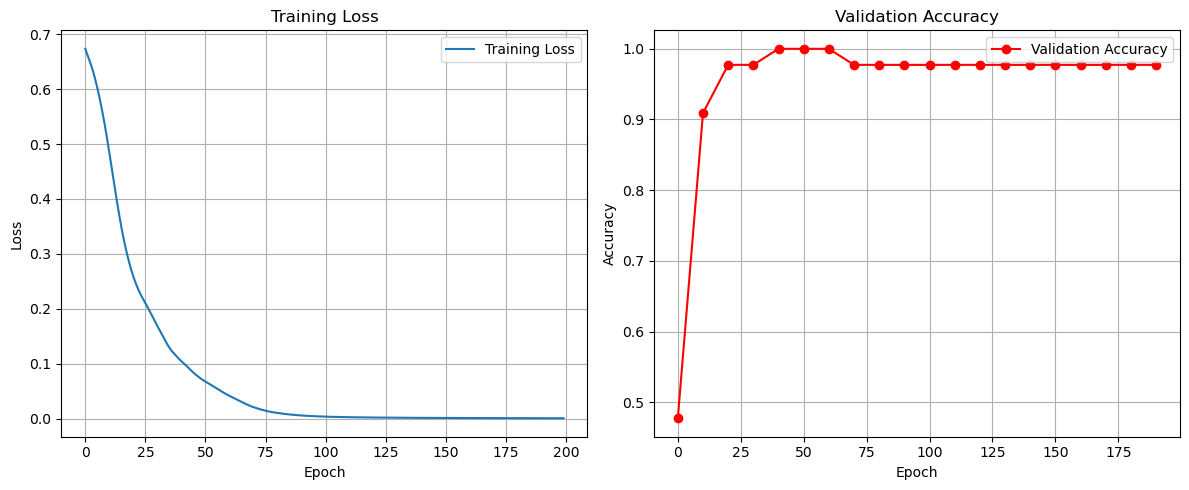

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
val_epochs = list(range(0, epochs, 10))  # Create matching x-axis values
plt.plot(val_epochs, val_accuracies, 'r-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### LLM Developed NN Implementation

In [ ]:
X_train = X_train_tensor.numpy().T   
y_train = y_train_tensor.numpy().reshape(1, -1)

X_test = X_test_tensor.numpy().T
y_test = y_test_tensor.numpy().reshape(1, -1)

X_train_np = X_train.T.astype(np.float32)  # (n_samples, n_features)
y_train_np = y_train.T.astype(np.float32)  # (n_samples, 1)

X_test_np = X_test.T.astype(np.float32)
y_test_np = y_test.T.astype(np.float32)

X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_test_np, y_test_np, test_size=0.5, random_state=42)

X_val = X_val_tensor.numpy().T
y_val = y_val_tensor.numpy().reshape(1, -1)


X_val_np = X_val.T.astype(np.float32)
y_val_np = y_val.T.astype(np.float32)


🔧 Training: activation=relu, layers=[32, 16]


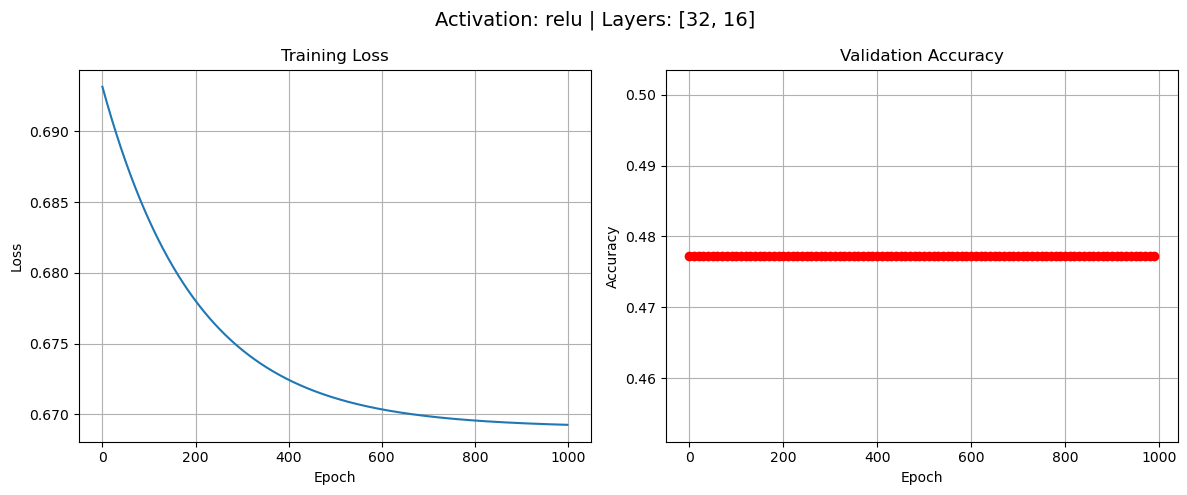


🔧 Training: activation=relu, layers=[64, 32]


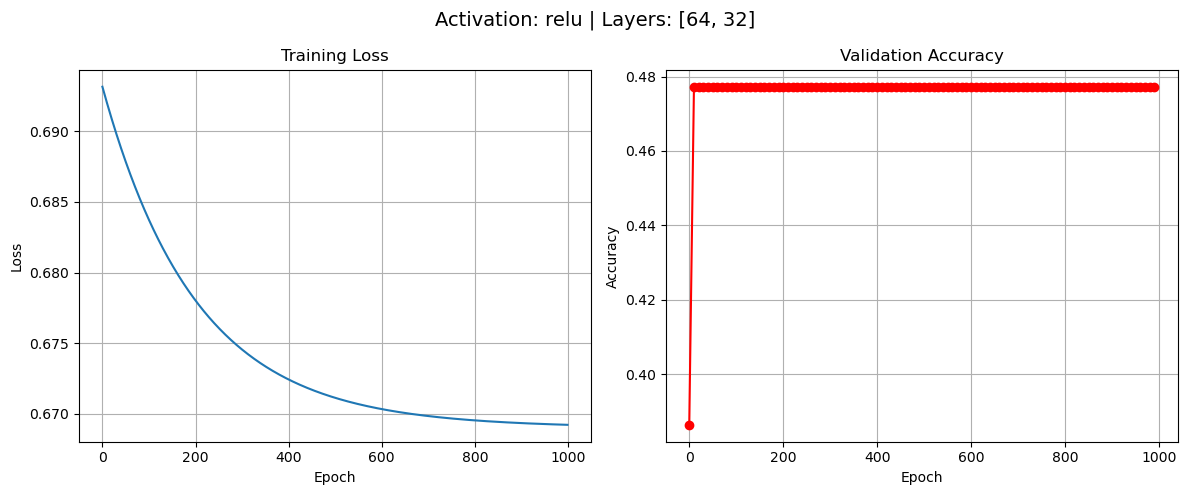


🔧 Training: activation=relu, layers=[128, 64, 32]


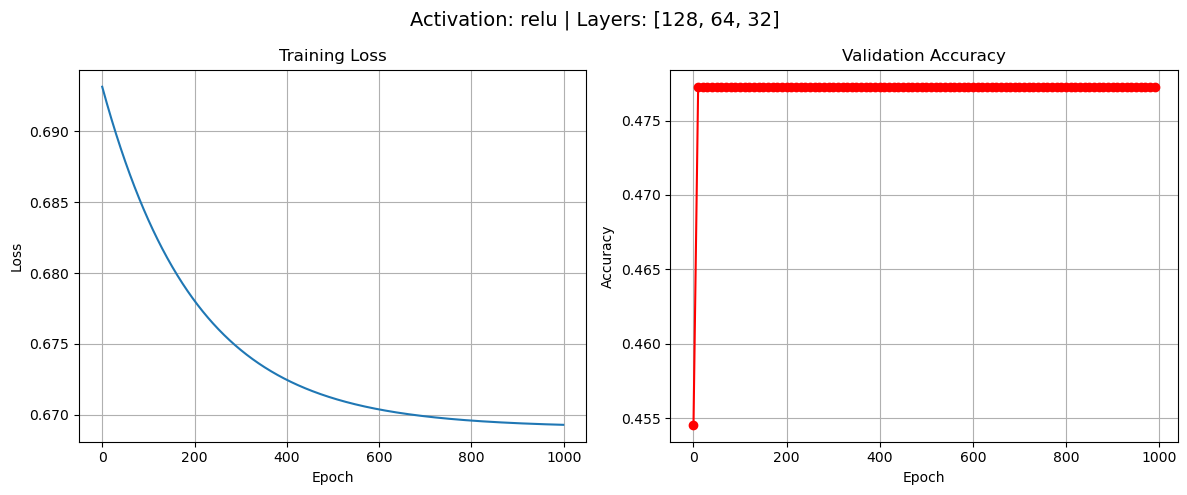


🔧 Training: activation=sigmoid, layers=[32, 16]


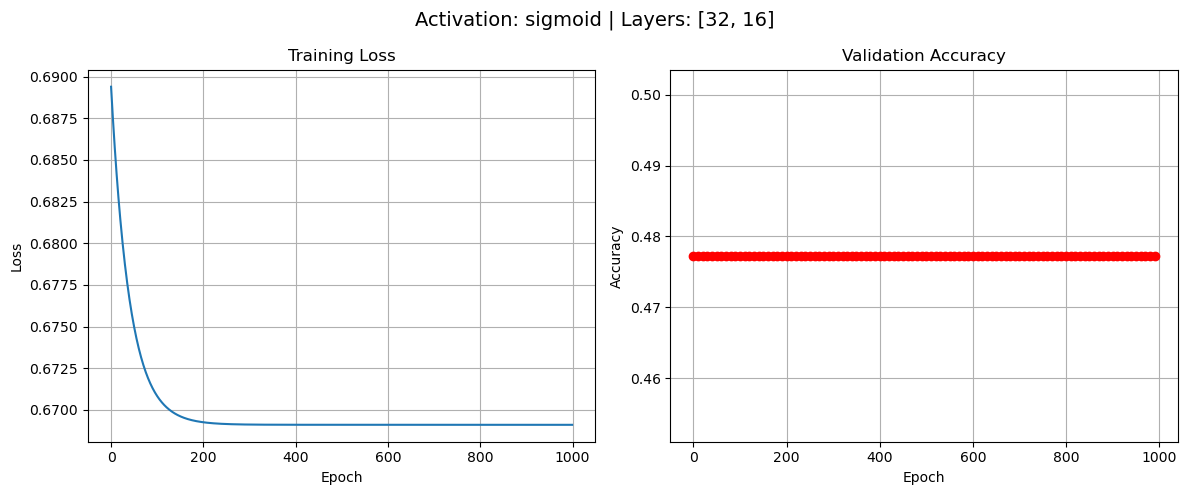


🔧 Training: activation=sigmoid, layers=[64, 32]


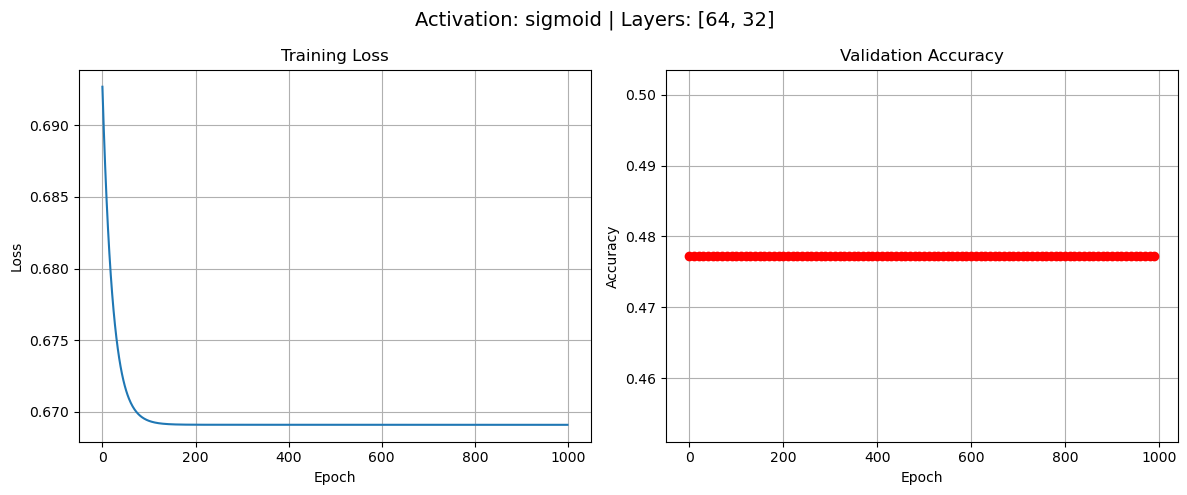


🔧 Training: activation=sigmoid, layers=[128, 64, 32]


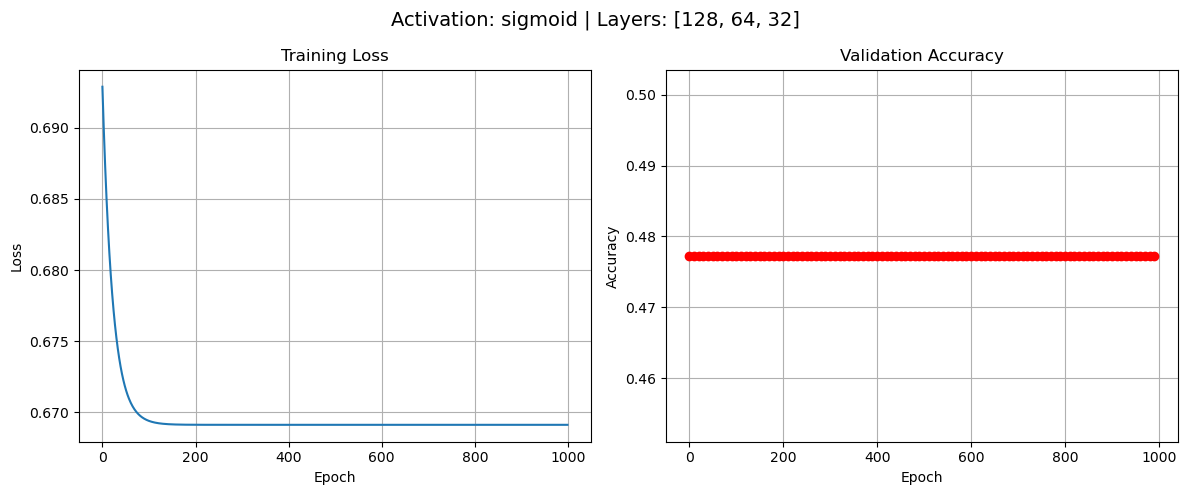


🔧 Training: activation=tanh, layers=[32, 16]


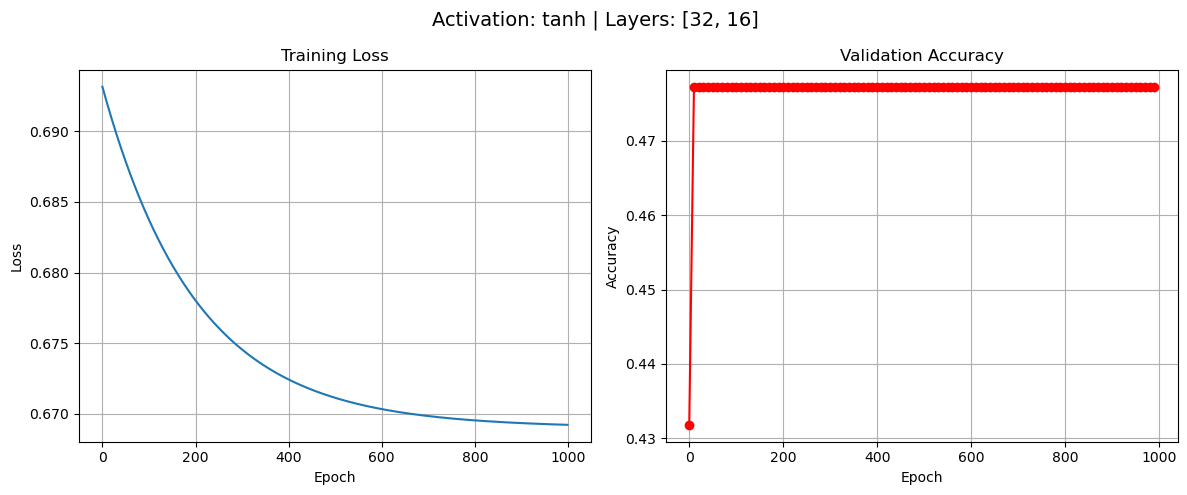


🔧 Training: activation=tanh, layers=[64, 32]


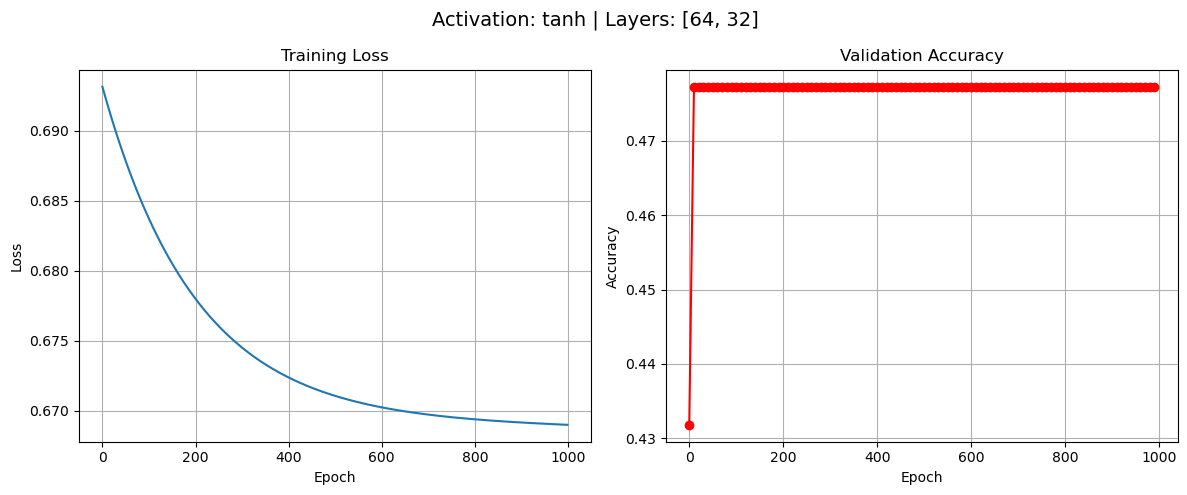


🔧 Training: activation=tanh, layers=[128, 64, 32]


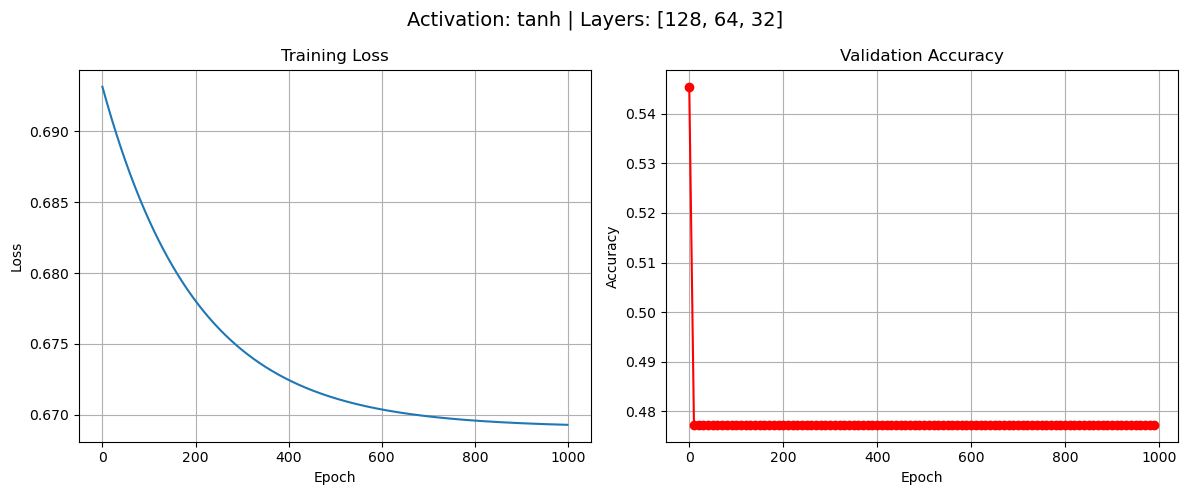


📊 Final Results (sorted by F1):
{'Activation': 'relu', 'Hidden Layers': '[32, 16]', 'Test Accuracy': 0.5455, 'Precision': 0.5455, 'Recall': 1.0, 'F1': 0.7059, 'Train Time (s)': 0.17, 'Params': 1089, 'Memory (MB)': 0.0083}
{'Activation': 'relu', 'Hidden Layers': '[64, 32]', 'Test Accuracy': 0.5455, 'Precision': 0.5455, 'Recall': 1.0, 'F1': 0.7059, 'Train Time (s)': 0.77, 'Params': 3201, 'Memory (MB)': 0.0244}
{'Activation': 'relu', 'Hidden Layers': '[128, 64, 32]', 'Test Accuracy': 0.5455, 'Precision': 0.5455, 'Recall': 1.0, 'F1': 0.7059, 'Train Time (s)': 1.98, 'Params': 12545, 'Memory (MB)': 0.0957}
{'Activation': 'sigmoid', 'Hidden Layers': '[32, 16]', 'Test Accuracy': 0.5455, 'Precision': 0.5455, 'Recall': 1.0, 'F1': 0.7059, 'Train Time (s)': 0.25, 'Params': 1089, 'Memory (MB)': 0.0083}
{'Activation': 'sigmoid', 'Hidden Layers': '[64, 32]', 'Test Accuracy': 0.5455, 'Precision': 0.5455, 'Recall': 1.0, 'F1': 0.7059, 'Train Time (s)': 0.93, 'Params': 3201, 'Memory (MB)': 0.0244}
{'Act

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import sys

sys.path.append('./nn_by_llm')
import nn

# Метрики
def evaluate_metrics(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = (y_pred > 0.5).astype(int)
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Precision': round(precision_score(y_true, y_pred, zero_division=0), 4),
        'Recall': round(recall_score(y_true, y_pred, zero_division=0), 4),
        'F1': round(f1_score(y_true, y_pred, zero_division=0), 4)
    }

def model_stats(params):
    total_params = 0
    memory = 0
    for key in params:
        total_params += params[key].size
        memory += params[key].nbytes
    return total_params, round(memory / (1024**2), 4)

# Конфигурации
activations_list = ['relu', 'sigmoid', 'tanh']
layer_configs = [[32, 16], [64, 32], [128, 64, 32]]
epochs = 200
eval_interval = 10
learning_rate = 0.01
results = []


# Перебор
for activation in activations_list:
    for config in layer_configs:
        print(f"\n🔧 Training: activation={activation}, layers={config}")

        # Архитектура
        layer_dims = [X_train_np.shape[1]] + config + [1]
        act_list = [activation] * len(config) + ['sigmoid']

        # Инициализация
        parameters = nn.initialize_parameters(layer_dims)
        train_losses = []
        val_accuracies = []

        start = time.time()

        for epoch in range(epochs):
            # Forward
            Y_hat, cache = nn.forward_propagation(X_train_np.T, parameters, act_list)

            # Loss
            loss = nn.compute_loss(Y_hat, y_train_np.T)
            train_losses.append(loss)

            # Validation
            if epoch % eval_interval == 0:
                val_pred, _ = nn.forward_propagation(X_val_np.T, parameters, act_list)
                acc = np.mean((val_pred > 0.5) == y_val_np.T)
                val_accuracies.append(acc)

            # Backward + update
            grads = nn.backward_propagation(X_train_np.T, y_train_np.T, parameters, cache, act_list)
            parameters = nn.update_parameters(parameters, grads, learning_rate)

        end = time.time()

        # Тест
        test_pred, _ = nn.forward_propagation(X_test_np.T, parameters, act_list)
        metrics = evaluate_metrics(y_test_np, test_pred.T)
        total_params, memory_mb = model_stats(parameters)

        results.append({
            "Activation": activation,
            "Hidden Layers": str(config),
            "Test Accuracy": metrics["Accuracy"],
            "Precision": metrics["Precision"],
            "Recall": metrics["Recall"],
            "F1": metrics["F1"],
            "Train Time (s)": round(end - start, 2),
            "Params": total_params,
            "Memory (MB)": memory_mb
        })

        # --- Графики ---
        plt.figure(figsize=(12, 5))
        plt.suptitle(f"Activation: {activation} | Layers: {config}", fontsize=14)

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()

        # Accuracy
        plt.subplot(1, 2, 2)
        val_epochs = list(range(0, epochs, eval_interval))
        plt.plot(val_epochs, val_accuracies, 'r-o')
        plt.title("Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid()

        plt.tight_layout()
        plt.show()

# --- Вывод ---
sorted_results = sorted(results, key=lambda x: x['F1'], reverse=True)
print("\n📊 Final Results (sorted by F1):")
for res in sorted_results:
    print(res)


In [ ]:
unique, counts = np.unique(y_test_np, return_counts=True)
print(dict(zip(unique, counts)))


{0.0: 10, 1.0: 12}


In [ ]:
# Convert tensors to numpy arrays and adjust shape
X_train = X_train_tensor.numpy().T   
y_train = y_train_tensor.numpy().reshape(1, -1)

X_val = X_val_tensor.numpy().T
y_val = y_val_tensor.numpy().reshape(1, -1)

import sys
sys.path.append('./nn_by_llm')

import nn

# Define network architecture
layer_dims = [X_train.shape[0], 10, 5, 1]
activations = ['relu', 'relu', 'sigmoid']

# Train
parameters = nn.train(X_train, y_train, layer_dims, activations, num_epochs=1000, learning_rate=0.01, print_loss=True)

# Predict
y_pred = nn.predict(X_val, parameters, activations)

# Compute accuracy
accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 0: Loss = 0.6931
Epoch 100: Loss = 0.6838
Epoch 200: Loss = 0.6781
Epoch 300: Loss = 0.6746
Epoch 400: Loss = 0.6725
Epoch 500: Loss = 0.6712
Epoch 600: Loss = 0.6704
Epoch 700: Loss = 0.6699
Epoch 800: Loss = 0.6696
Epoch 900: Loss = 0.6694
Validation Accuracy: 47.73%


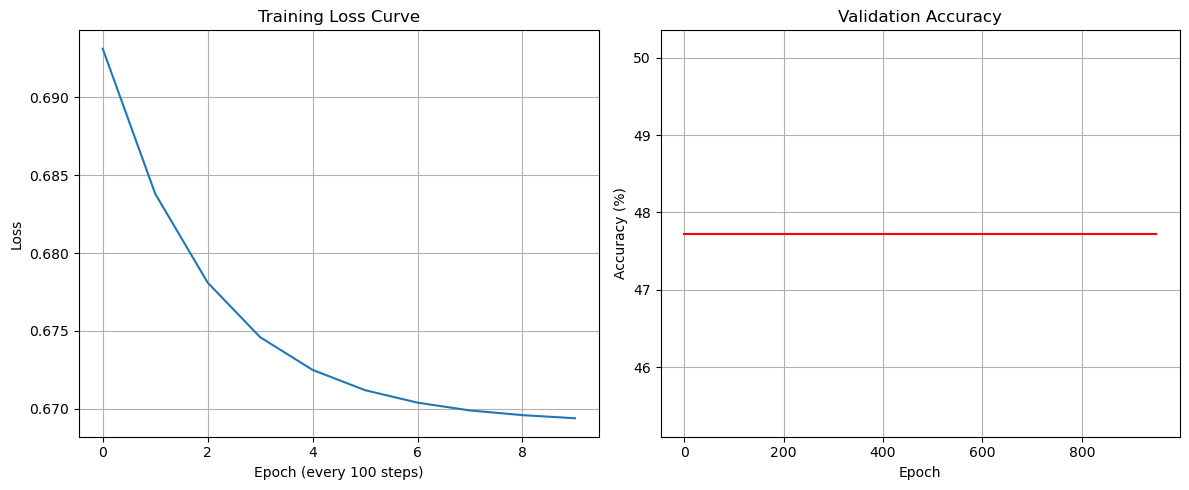

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Convert tensors to numpy arrays and adjust shape
X_train = X_train_tensor.numpy().T   
y_train = y_train_tensor.numpy().reshape(1, -1)
X_val = X_val_tensor.numpy().T
y_val = y_val_tensor.numpy().reshape(1, -1)

# Define network architecture
layer_dims = [X_train.shape[0], 10, 5, 1]
activations = ['relu', 'relu', 'sigmoid']

# Initialize lists to track metrics
loss_history = []
val_accuracy_history = []
eval_interval = 50  # Evaluate every 50 epochs

# We'll use this wrapper to capture loss values from print statements
class LossCapture:
    def __init__(self):
        self.losses = []
    
    def write(self, text):
        if "Loss = " in text:
            loss = float(text.split("Loss = ")[1].strip())
            self.losses.append(loss)

# Redirect print output to our capture class
loss_capture = LossCapture()
import sys
sys.stdout = loss_capture

# Train the model (this will populate loss_capture.losses via print statements)
parameters = nn.train(X_train, y_train, layer_dims, activations, 
                     num_epochs=1000, learning_rate=0.01, print_loss=True)

# Restore stdout
sys.stdout = sys.__stdout__

# Now calculate validation accuracies at intervals
for epoch in range(0, 1000, eval_interval):
    y_pred = nn.predict(X_val, parameters, activations)
    accuracy = np.mean(y_pred == y_val)
    val_accuracy_history.append((epoch, accuracy))
    print(f"Epoch {epoch}: Val Acc = {accuracy*100:.2f}%")

# Final evaluation
y_pred = nn.predict(X_val, parameters, activations)
final_accuracy = np.mean(y_pred == y_val)
print(f"\nFinal Validation Accuracy: {final_accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Loss curve (from captured print output)
plt.subplot(1, 2, 1)
plt.plot(loss_capture.losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch (every 100 steps)")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
epochs, accuracies = zip(*val_accuracy_history)
plt.plot(epochs, [acc*100 for acc in accuracies], 'r-')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

The validation plot indicates potential issues with your model's learning process. The accuracy only improves from 46% to 50% over 800 epochs which is barely significant.  

### Existing NN implemention (sklearn-MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Преобразуем тензоры в numpy
X_train_np = X_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_train_np = y_train_tensor.numpy().ravel()
y_val_np = y_val_tensor.numpy().ravel()

# Создаем модель
mlp = MLPClassifier(hidden_layer_sizes=(10, 5),  # 2 скрытых слоя
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.01,
                    max_iter=1000,
                    random_state=42)

# Обучение модели
mlp.fit(X_train_np, y_train_np)

# Предсказания
y_pred = mlp.predict(X_val_np)

# Метрики
accuracy = accuracy_score(y_val_np, y_pred)
precision = precision_score(y_val_np, y_pred, zero_division=0)
recall = recall_score(y_val_np, y_pred, zero_division=0)
f1 = f1_score(y_val_np, y_pred, zero_division=0)

# Вывод
print(f"Validation Accuracy (sklearn MLP): {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Validation Accuracy (sklearn MLP): 97.73%
Precision: 0.9545
Recall: 1.0000
F1 Score: 0.9767


### Comparison Across the Three Implemtations